# Amazon Review Data 
##(Beauty and Clothes-Shoes-Jewelry) 

Specific Problems:
1. Based on the ‘review text’ and ‘summary’ of the data, identify how a review can be classified into a particular category (for example, positive, negative and neutral).
Analyse the text well to build the categories. In case of many negative sentiments associated with a product, try to find out the reasons.
2. Identify the names of few products by analysing your input text data.
3. Predict future data trends: How the sentiments of reviewers change with time. Suppose input data is provided for the period 1996-2014.
Your task is to predict the trends after 2014.
4. Can you find any relations/buying trends of customers/any other interesting analysis between given pair of categories (Example, Beauty and Clothing categories)Note: The analysis and outcomes should be based on given input data only, not your assumptions or any other information outside the data.

# Importing necessary Libraries and Data

In [19]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.3 MB/s 
     |████████████████████████████████| 9.8 MB 54.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import pandas as pd
import numpy as np
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
# from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
brate=pd.read_csv('/content/drive/MyDrive/ratings_Beauty.csv',header=None)
brev=pd.read_json('/content/drive/MyDrive/Beauty_5.json',lines=True,orient='records')
crate=pd.read_csv('/content/drive/MyDrive/ratings_Clothing_Shoes_and_Jewelry.csv',header=None)
crev=pd.read_json('/content/drive/MyDrive/Clothing_Shoes_and_Jewelry_5.json',lines=True,orient='records')

In [4]:
brate.head(1)

,0,1,2,3
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200


In [5]:
brev.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"


In [6]:
crate.head(1)

,0,1,2,3
0,A2XVJBSRI3SWDI,0000031887,5.0,1383523200


In [7]:
crev.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"


In [8]:
brate.shape[0]+crate.shape[0],crev.shape[0]+brev.shape[0]

(7771990, 477179)

# Preparing the Dataset

Rename the columns

In [9]:
brate.rename(columns={0:'reviewerID',1:'productID',2:'rating',3:'ReviewDate'},inplace=True)
crate.rename(columns={0:'reviewerID',1:'productID',2:'rating',3:'ReviewDate'},inplace=True)
brev.rename(columns={'asin':'productID','unixReviewTime':'ReviewDate'},inplace=True)
crev.rename(columns={'asin':'productID','unixReviewTime':'ReviewDate'},inplace=True)

Type Casting

In [10]:
brate['ReviewDate']=pd.to_datetime(brate['ReviewDate'],unit='s')
brev['ReviewDate']=pd.to_datetime(brev['ReviewDate'],unit='s')
crate['ReviewDate']=pd.to_datetime(crate['ReviewDate'],unit='s')
crev['ReviewDate']=pd.to_datetime(crev['ReviewDate'],unit='s')

Adding New Feature

In [11]:
brate['category']='Beauty'
brev['category']='Beauty'
crate['category']='Clothing-Shoes-Jewelry'
crev['category']='Clothing-Shoes-Jewelry'

Shape

In [12]:
brate.shape,brev.shape,crate.shape,crev.shape

((2023070, 5), (198502, 10), (5748920, 5), (278677, 10))

Feature Engineering

In [13]:
temp=pd.DataFrame(brev['helpful'].to_list(),columns=('helpfulNum','helpfulDen'))
brev['helpful']=temp['helpfulNum']/temp['helpfulDen']
brev['helpful'].fillna(0,inplace=True)

In [14]:
temp=pd.DataFrame(crev['helpful'].to_list(),columns=('helpfulNum','helpfulDen'))
crev['helpful']=temp['helpfulNum']/temp['helpfulDen']
crev['helpful'].fillna(0,inplace=True)

**Concatenating the data**

In [15]:
rate=pd.concat([brate,crate],axis=0)

In [16]:
review=pd.concat([brev,crev],axis=0)

In [17]:
review.drop('reviewTime',inplace=True,axis=1)

**Null value treatment**

In [18]:
review.drop('reviewerName', axis=1,inplace=True)

# Text Preprocessing and Analysis

In [19]:
review['review']=review['reviewText']+' '+review['summary']
review.drop(['reviewText','summary'],axis=1,inplace=True)

**Contraction to expansion**

In [20]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
"wouldn't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}

In [21]:
def cont_to_exp(x):
  if x in contractions.keys():
    value=contractions[x]
  else:
    value=x
  return value

**Removing Emails, Websites, Non-Alpha characters and Lemmatize the string**

In [22]:
# %%timeit
lem = WordNetLemmatizer()
def preprocess(x):

  x = x.lower()
  x = ' '.join(list((cont_to_exp(t) for t in x.split())))
  x = re.sub('[^a-zA-Z]', ' ',x)
  x = re.sub('(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','', x)
  x = re.sub('([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)','',x)
  x = re.sub('[\W+]', ' ', x)
  x = ' '.join(list((lem.lemmatize(t) for t in x.split() if t not in stopwords)))
  x = ' '.join(list((t for t in x.split() if len(t)>1)))
  return x

In [23]:
review['pro_review']=review['review'].apply(lambda x :  preprocess(x))

# Sentiment Analysis

In [24]:
# review

### Using Features and ML Model

Adding sentiment to the product review on the grounds of rating given by a user for the particular product (Positive ,Negative & Neutral).
Dependent feature for classification machine learning model  
overall > 3 : Positive  
overall == 3 : Neutral  
overall < 3 : Negative

In [25]:
review.loc[(review["overall"] > 3) , 'sentiment'] = 'Positive'
review.loc[(review["overall"] == 3) , 'sentiment'] = 'Neutral'
review.loc[(review["overall"] < 3) , 'sentiment'] = 'Negative'

**Vectorize the string**

In [26]:
X1=review['pro_review']
y1=review['sentiment']

In [27]:
tf=TfidfVectorizer(max_features=1500)
text_tf= tf.fit_transform(X1)

**Splitting the data**

In [28]:
X, X_test, y, y_test = train_test_split(text_tf, y1, test_size=0.5, random_state=0)

**Model Building**

In [29]:
# rfc1 = RandomForestClassifier(criterion='entropy', n_estimators=200).fit(X, y)
# s = rfc1.score(X_test, y_test)
# print(s)

In [30]:
import pickle
# pickle.dump(rfc1,open('test2.pkl','wb'))

In [31]:
model = pickle.load(open('/content/drive/MyDrive/test2.pkl','rb'))

In [32]:
s = model.score(text_tf, y1) # Complete data
print(s)

0.9141894341536405


In [33]:
s = model.score(X_test, y_test) # Test data
print(s)

0.8286307053941909


In [34]:
s = model.score(X, y) # Train data
print(s)

0.99974852151608


**Prediction**

In [35]:
pred=model.predict(text_tf)

In [36]:
review['pred_sentiment']=pred

In [37]:
review[review['sentiment']!=review['pred_sentiment']].shape,review.shape

((40947, 10), (477179, 10))

In [38]:
(477179-40947)/477179

0.9141894341536405

### Text Blob (Polarity)

In [39]:
review['polarity']=review['review'].apply( lambda x : TextBlob(x).sentiment.polarity)

In [40]:
review.loc[(review["polarity"] > 0) , 'blob_sentiment'] = 'Positive'
review.loc[(review["polarity"] == 0) , 'blob_sentiment'] = 'Neutral'
review.loc[(review["polarity"] < 0) , 'blob_sentiment'] = 'Negative'

In [41]:
review[review['sentiment']!=review['blob_sentiment']].shape,review.shape

((94998, 12), (477179, 12))

In [42]:
(477179-94998)/477179

0.8009174754127906

### Graphs

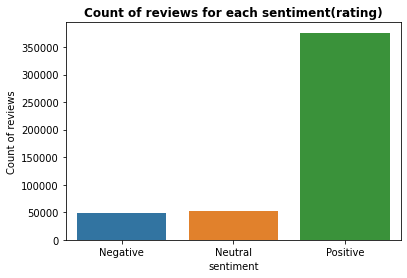

In [43]:
sns.countplot(review['sentiment'])
plt.ylabel('Count of reviews')
plt.title('Count of reviews for each sentiment(rating)',fontweight='bold')
plt.show()

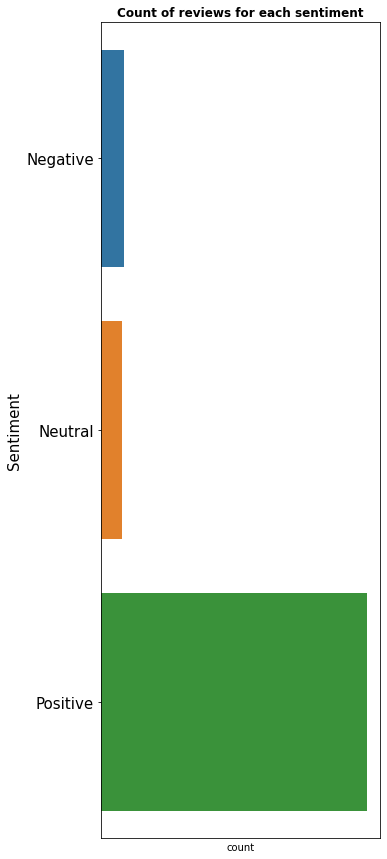

In [44]:
fig ,a = plt.subplots(figsize=(5,15))
ax=sns.countplot(y=review['pred_sentiment'])
plt.ylabel('Sentiment',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks([])
plt.title('Count of reviews for each sentiment',fontweight='bold')
plt.show()

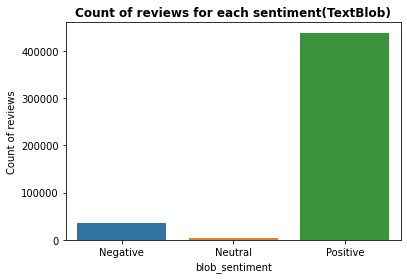

In [45]:
sns.countplot(review['blob_sentiment'].sort_values())
plt.ylabel('Count of reviews')
plt.title('Count of reviews for each sentiment(TextBlob)',fontweight='bold')
plt.show()

# Analysis of Products with Negative Sentiment

In [46]:
df=review[review['pred_sentiment']=='Negative'].value_counts('productID').reset_index(name='count')

In [47]:
len(df)

17540

In [48]:
Worstproduct=df['productID'][df['count']>=20]

In [49]:
index=[]
for x in range(len(review)):
  if (review.iloc[x,1] in list(Worstproduct)) & (review.iloc[x,-3] == 'Negative'):
    index.append(x)

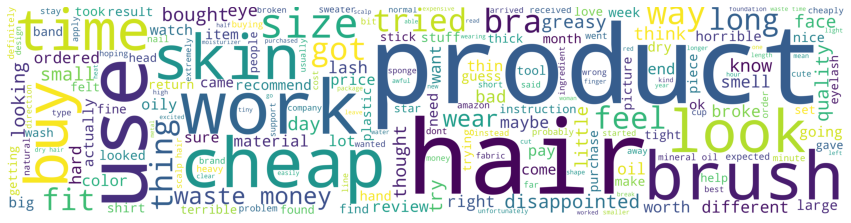

In [50]:
import re 

text =re.sub('good|better|pretty|great','',' '.join(review.iloc[index,7]))
wc = WordCloud(background_color='white',width=8000, height=2000).generate(text)
plt.figure(figsize=(15,12))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [51]:
df=review[review['pred_sentiment']=='Positive'].value_counts('productID').reset_index(name='count')

In [52]:
len(df)

35119

In [53]:
Worstproduct=df['productID'][df['count']>=20]

In [54]:
index=[]
for x in range(len(review)):
  if (review.iloc[x,1] in list(Worstproduct)) & (review.iloc[x,-3] == 'Positive'):
    index.append(x)

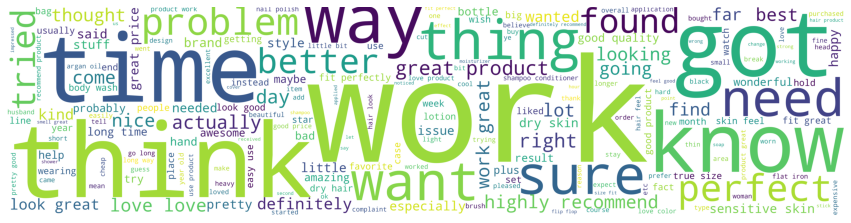

In [55]:
import re 

text =' '.join(review.iloc[index,7])
wc = WordCloud(background_color='white',width=8000, height=2000).generate(text)
plt.figure(figsize=(15,12))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [56]:
df=review[review['pred_sentiment']=='Neutral'].value_counts('productID').reset_index(name='count')

In [57]:
len(df)

16613

In [58]:
Worstproduct=df['productID'][df['count']>=20]

In [59]:
index=[]
for x in range(len(review)):
  if (review.iloc[x,1] in list(Worstproduct)) & (review.iloc[x,-3] == 'Neutral'):
    index.append(x)

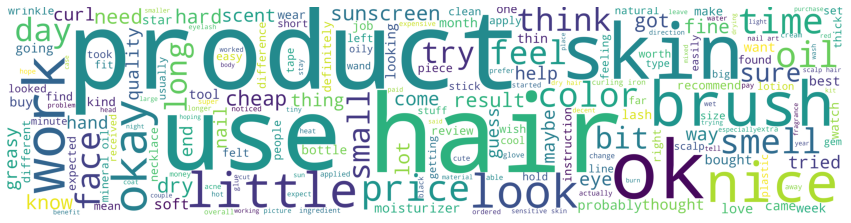

In [60]:
import re 

text =re.sub('good|better|pretty|great|bad','',' '.join(review.iloc[index,7]))
wc = WordCloud(background_color='white',width=8000, height=2000).generate(text)
plt.figure(figsize=(15,12))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [61]:
text= ' '.join(review.iloc[index,7])

In [62]:
text=text.split()
freq=pd.Series(text).value_counts().reset_index(name='count')

In [63]:
freq.set_index('index',inplace=True)

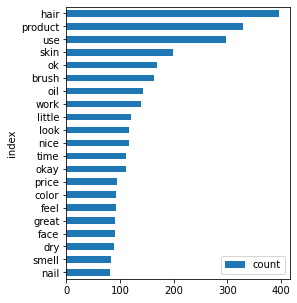

In [66]:
freq[:24].sort_values(by='count').drop(['like','good','better']).plot(kind='barh',figsize=(4,5));

In [67]:
review.groupby(['productID'])['pred_sentiment'].value_counts()  

productID   pred_sentiment
0000031887  Positive          21
            Negative           1
            Neutral            1
0123456479  Positive           4
            Neutral            2
                              ..
B00L6Q3BH6  Positive           4
            Neutral            1
B00LCEROA2  Positive           9
B00LG63DOM  Positive          10
B00LLPT4HI  Positive           7
Name: pred_sentiment, Length: 69272, dtype: int64

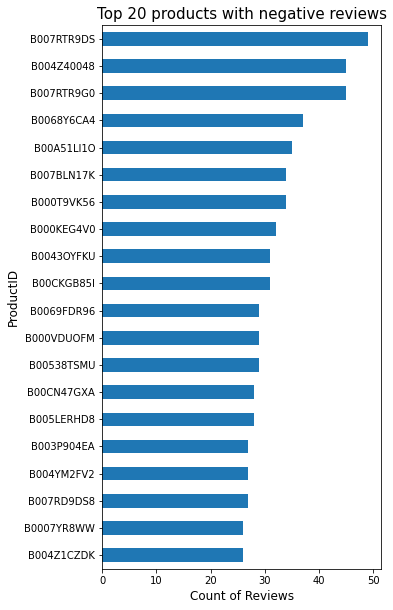

In [68]:
review[(review.pred_sentiment=='Negative')]['productID'].value_counts().iloc[:20].sort_values().plot(kind='barh',figsize=(5,10))
plt.xlabel('Count of Reviews',fontsize=12)
plt.ylabel('ProductID',fontsize=12)
plt.title('Top 20 products with negative reviews',fontsize=15);

In [69]:
review[review['productID']=='B007RTR9G0']['pred_sentiment'].value_counts()

Positive    119
Negative     45
Neutral      26
Name: pred_sentiment, dtype: int64

In [70]:
# review[['review','pred_sentiment']][(review['productID']=='B007RTR9G0') & (review['pred_sentiment']=='Negative')]

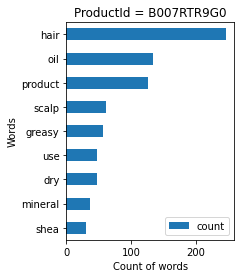

In [71]:
text= ' '.join(review['pro_review'][(review['productID']=='B007RTR9G0')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq1=pd.Series(text).value_counts().reset_index(name='count')
freq1.set_index('index',inplace=True)
freq1[:10].sort_values(by='count').drop(['like'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B007RTR9G0')
plt.xlabel('Count of words')
plt.ylabel('Words');

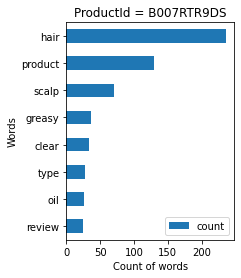

In [72]:
text= ' '.join(review['pro_review'][(review['productID']=='B007RTR9DS')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq2=pd.Series(text).value_counts().reset_index(name='count')
freq2.set_index('index',inplace=True)
freq2[:10].sort_values(by='count').drop(['like','use'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B007RTR9DS')
plt.xlabel('Count of words')
plt.ylabel('Words');

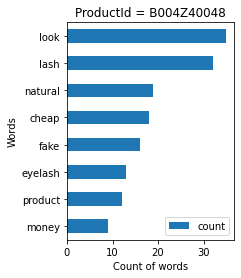

In [73]:
text= ' '.join(review['pro_review'][(review['productID']=='B004Z40048')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq3=pd.Series(text).value_counts().reset_index(name='count')
freq3.set_index('index',inplace=True)
freq3[:10].sort_values(by='count').drop(['like','good'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B004Z40048')
plt.xlabel('Count of words')
plt.ylabel('Words');

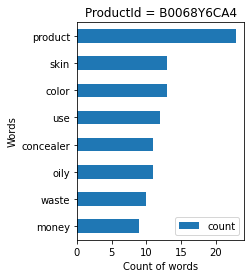

In [74]:
text= ' '.join(review['pro_review'][(review['productID']=='B0068Y6CA4')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq4=pd.Series(text).value_counts().reset_index(name='count')
freq4.set_index('index',inplace=True)
freq4[:10].sort_values(by='count').drop(['like','buy']).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B0068Y6CA4')
plt.xlabel('Count of words')
plt.ylabel('Words');

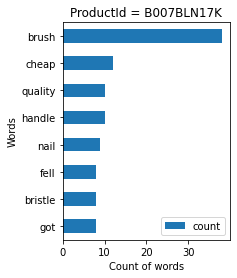

In [75]:
text= ' '.join(review['pro_review'][(review['productID']=='B007BLN17K')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq5=pd.Series(text).value_counts().reset_index(name='count')
freq5.set_index('index',inplace=True)
freq5[:10].sort_values(by='count').drop(['like','good'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B007BLN17K')
plt.xlabel('Count of words')
plt.ylabel('Words');

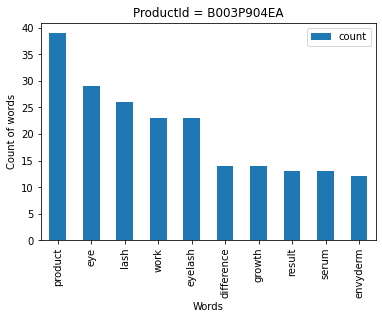

In [76]:
text= ' '.join(review['pro_review'][(review['productID']=='B003P904EA')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq5=pd.Series(text).value_counts().reset_index(name='count')
freq5.set_index('index',inplace=True)
freq5[:10].plot(kind='bar')
plt.title('ProductId = B003P904EA')
plt.ylabel('Count of words')
plt.xlabel('Words');

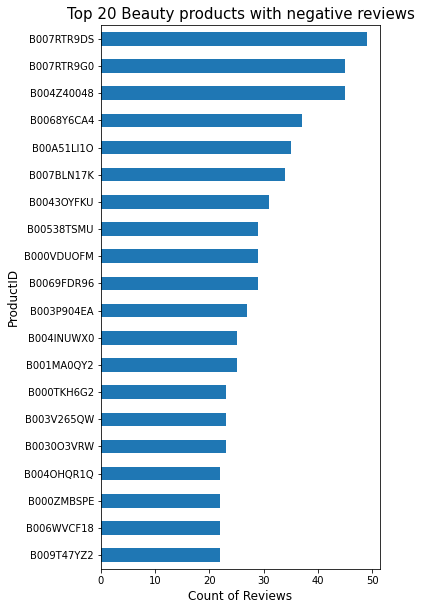

In [77]:
review[(review.pred_sentiment=='Negative')&(review.category=='Beauty')]['productID'].value_counts().iloc[:20].sort_values().plot(kind='barh',figsize=(5,10))
plt.xlabel('Count of Reviews',fontsize=12)
plt.ylabel('ProductID',fontsize=12)
plt.title('Top 20 Beauty products with negative reviews',fontsize=15);

In [ ]:
review[(review.pred_sentiment=='Negative')&(review.category=='Beauty')]['productID'].value_counts().iloc[:20]

B007RTR9DS    49
B007RTR9G0    45
B004Z40048    45
B0068Y6CA4    37
B00A51LI1O    35
B007BLN17K    34
B0043OYFKU    31
B000VDUOFM    29
B00538TSMU    29
B0069FDR96    29
B003P904EA    27
B004INUWX0    25
B001MA0QY2    25
B000TKH6G2    23
B003V265QW    23
B0030O3VRW    23
B000ZMBSPE    22
B006WVCF18    22
B004OHQR1Q    22
B009T47YZ2    22
Name: productID, dtype: int64

In [ ]:
# review[['review','pred_sentiment']][(review['productID']=='B007RTR9G0') & (review['pred_sentiment']=='Negative')]

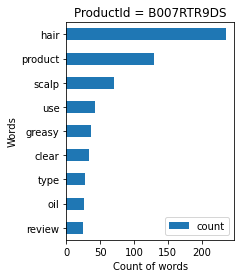

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B007RTR9DS')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq2=pd.Series(text).value_counts().reset_index(name='count')
freq2.set_index('index',inplace=True)
freq2[:10].sort_values(by='count').drop(['like'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B007RTR9DS')
plt.xlabel('Count of words')
plt.ylabel('Words');

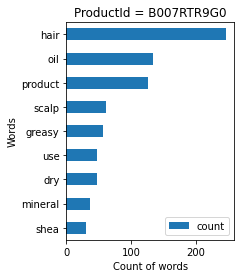

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B007RTR9G0')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq1=pd.Series(text).value_counts().reset_index(name='count')
freq1.set_index('index',inplace=True)
freq1[:10].sort_values(by='count').drop(['like'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B007RTR9G0')
plt.xlabel('Count of words')
plt.ylabel('Words');

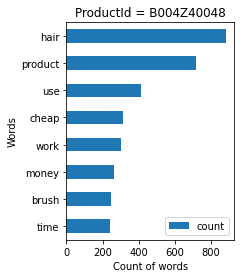

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B004Z40048')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq4=pd.Series(text).value_counts().reset_index(name='count')
freq4.set_index('index',inplace=True)
freq[:10].sort_values(by='count').drop(['like','good']).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B004Z40048')
plt.xlabel('Count of words')
plt.ylabel('Words');

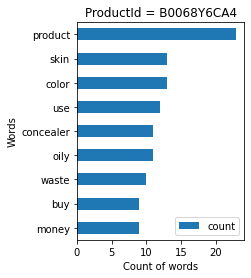

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B0068Y6CA4')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq5=pd.Series(text).value_counts().reset_index(name='count')
freq5.set_index('index',inplace=True)
freq5[:10].sort_values(by='count').drop(['like'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B0068Y6CA4')
plt.xlabel('Count of words')
plt.ylabel('Words');

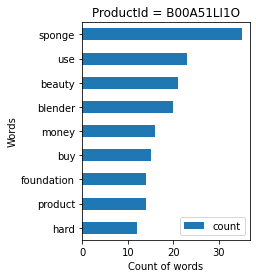

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B00A51LI1O')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq5=pd.Series(text).value_counts().reset_index(name='count')
freq5.set_index('index',inplace=True)
freq5[:10].sort_values(by='count').drop(['like'],axis=0).plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B00A51LI1O')
plt.xlabel('Count of words')
plt.ylabel('Words');

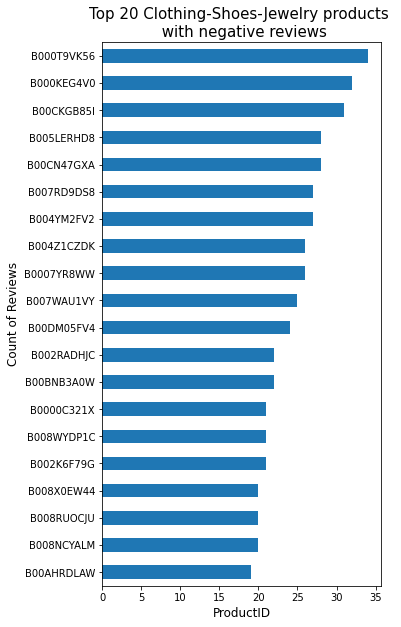

In [ ]:
review[(review.pred_sentiment=='Negative')&(review.category=='Clothing-Shoes-Jewelry')]['productID'].value_counts().iloc[:20].sort_values().plot(kind='barh',figsize=(5,10))
plt.ylabel('Count of Reviews',fontsize=12)
plt.xlabel('ProductID',fontsize=12)
plt.title('Top 20 Clothing-Shoes-Jewelry products \n with negative reviews',fontsize=15);


In [ ]:
review[(review.pred_sentiment=='Negative')&(review.category=='Clothing-Shoes-Jewelry')]['productID'].value_counts().iloc[:20]

B000T9VK56    34
B000KEG4V0    32
B00CKGB85I    31
B005LERHD8    28
B00CN47GXA    28
B007RD9DS8    27
B004YM2FV2    27
B0007YR8WW    26
B004Z1CZDK    26
B007WAU1VY    25
B00DM05FV4    24
B002RADHJC    22
B00BNB3A0W    22
B0000C321X    21
B008WYDP1C    21
B002K6F79G    21
B008RUOCJU    20
B008NCYALM    20
B008X0EW44    20
B00AHRDLAW    19
Name: productID, dtype: int64

In [ ]:
# review[['review','pred_sentiment']][(review['productID']=='B007RTR9G0') & (review['pred_sentiment']=='Negative')]

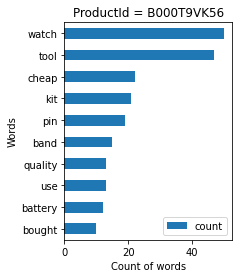

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B000T9VK56')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq1=pd.Series(text).value_counts().reset_index(name='count')
freq1.set_index('index',inplace=True)
freq1[:10].sort_values(by='count').plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B000T9VK56')
plt.xlabel('Count of words')
plt.ylabel('Words');

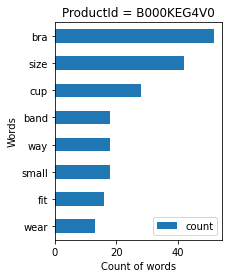

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B000KEG4V0')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq2=pd.Series(text).value_counts().reset_index(name='count')
freq2.set_index('index',inplace=True)
freq2[:10].drop(['like','good'],axis=0).sort_values(by='count').plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B000KEG4V0')
plt.xlabel('Count of words')
plt.ylabel('Words');

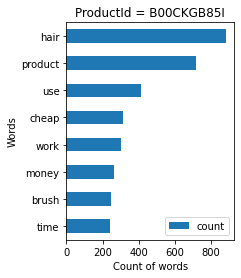

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B00CKGB85I')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq4=pd.Series(text).value_counts().reset_index(name='count')
freq4.set_index('index',inplace=True)
freq[:10].drop(['like','good']).sort_values(by='count').plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B00CKGB85I')
plt.xlabel('Count of words')
plt.ylabel('Words');

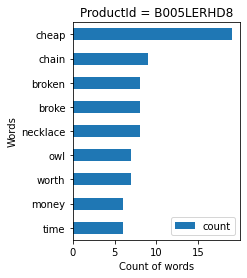

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B005LERHD8')& (review['pred_sentiment']=='Negative')])
text=text.split()
freq5=pd.Series(text).value_counts().reset_index(name='count')
freq5.set_index('index',inplace=True)
freq5[:10].drop(['cute'],axis=0).sort_values(by='count').plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B005LERHD8')
plt.xlabel('Count of words')
plt.ylabel('Words');

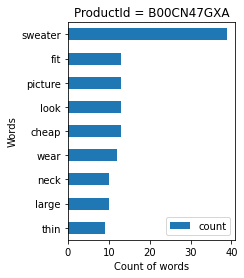

In [ ]:
text= ' '.join(review['pro_review'][(review['productID']=='B00CN47GXA') & (review['pred_sentiment']=='Negative')])
text=text.split()
freq5=pd.Series(text).value_counts().reset_index(name='count')
freq5.set_index('index',inplace=True)
freq5[:10].drop(['like'],axis=0).sort_values(by='count').plot(kind='barh',figsize=(3,4))
plt.title('ProductId = B00CN47GXA')
plt.xlabel('Count of words')
plt.ylabel('Words');

# Time Series Analysis

In [ ]:
trial = review.copy()
trial.set_index('ReviewDate',drop=True,inplace=True)
trial.sort_index(inplace=True)

In [ ]:
trial.head(1)

,reviewerID,productID,helpful,overall,category,review,pro_review,sentiment,pred_sentiment,polarity,blob_sentiment
ReviewDate,,,,,,,,,,,
2002-06-12,A281NPSIMI1C2R,B0000535UX,0.0,5,Beauty,I've been using Jason's products for over ten ...,jason product year favorite hand soap like unl...,Positive,Positive,0.188542,Positive


In [ ]:
trial.shape

(477179, 11)

In [ ]:
def checkStationarity(test):
    pvalue = adfuller(test)[1]
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
    return(msg)

## Using Count (Feature Method) for **BEAUTY** Dataset

In [ ]:
positive=trial[(trial['pred_sentiment']=='Positive') & (trial['category']=='Beauty')]
negative=trial[(trial['pred_sentiment']=='Negative') & (trial['category']=='Beauty')]
neutral=trial[(trial['pred_sentiment']=='Neutral') & (trial['category']=='Beauty')]

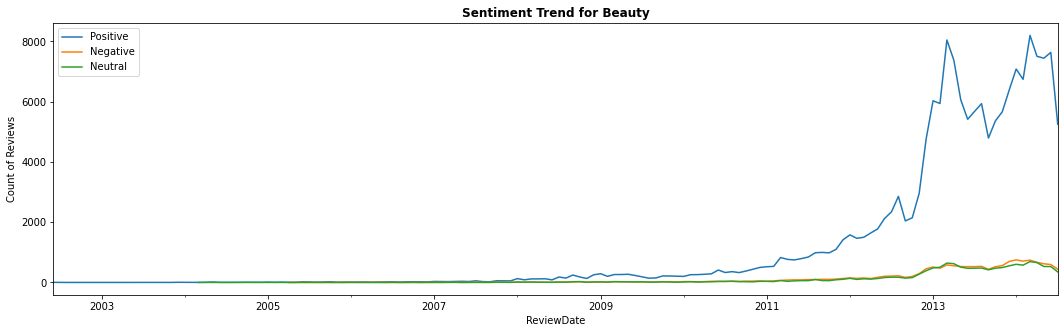

In [ ]:
positive['productID'].resample('M').count().plot(figsize=(18,5),label='Positive')
negative['productID'].resample('M').count().plot(figsize=(18,5),label='Negative')
neutral['productID'].resample('M').count().plot(figsize=(18,5),label='Neutral')
plt.legend()
plt.title('Sentiment Trend for Beauty',fontweight='bold')
plt.ylabel('Count of Reviews');

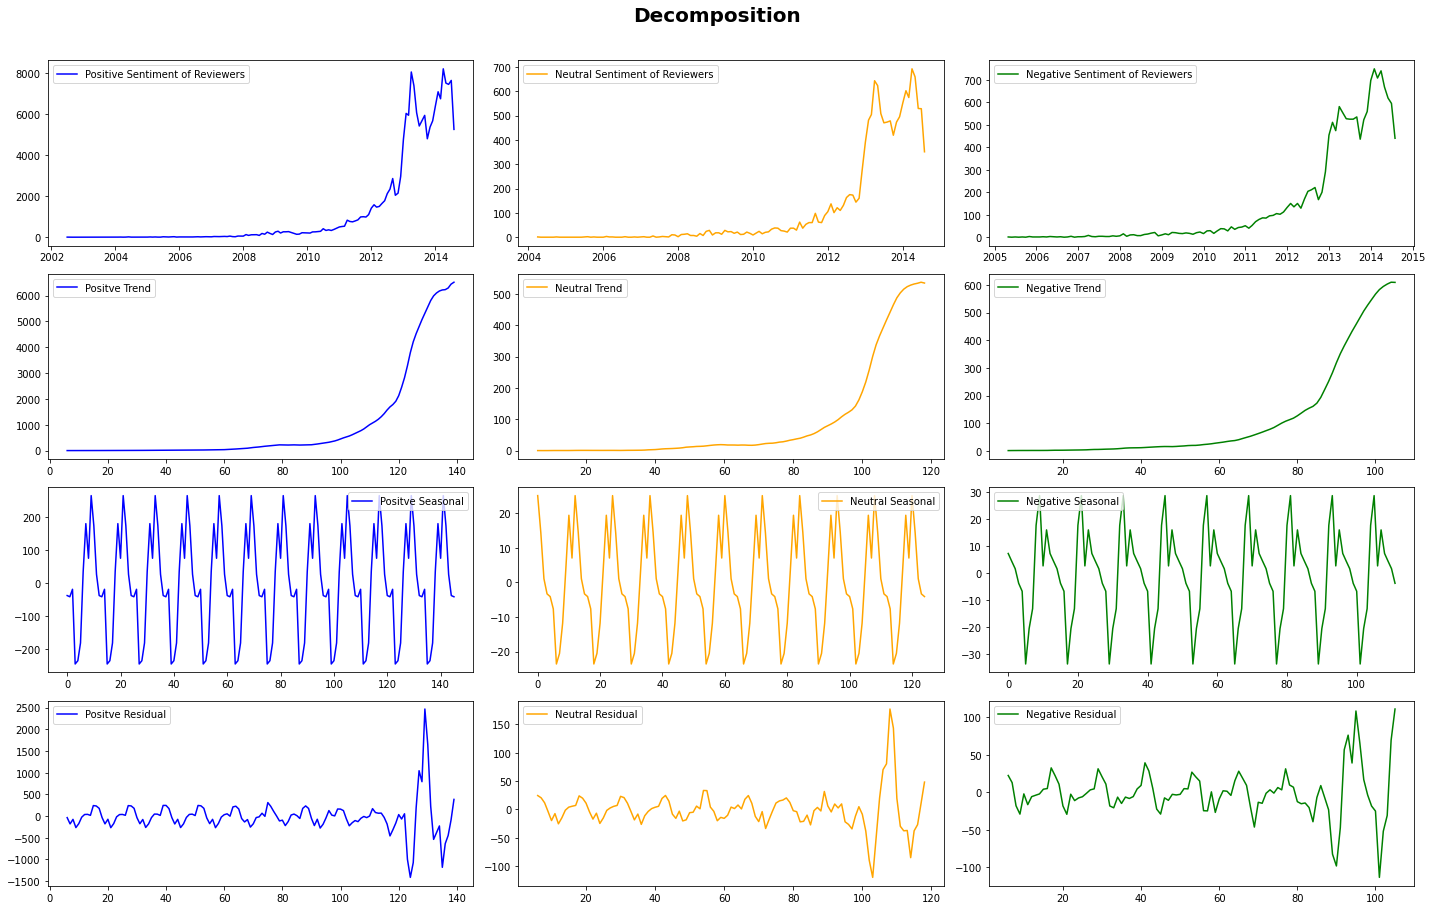

In [ ]:
# Decomposition plot for predicted data using Features
decomposition_p=seasonal_decompose(np.asarray(positive['productID'].resample('M').count()), period=12)
d_trend_p=decomposition_p.trend
d_seasonal_p=decomposition_p.seasonal
d_residual_p=decomposition_p.resid
decomposition=seasonal_decompose(np.asarray(neutral['productID'].resample('M').count()), period=12)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid
decomposition_n=seasonal_decompose(np.asarray(negative['productID'].resample('M').count()), period=12)
d_trend_n=decomposition_n.trend
d_seasonal_n=decomposition_n.seasonal
d_residual_n=decomposition_n.resid
# plotting all the 4 graphs
fig,ax = plt.subplots(4,3,figsize=(20,12))
plt.subplot(4,3,1)
plt.plot(positive['productID'].resample('M').count(),label='Positive Sentiment of Reviewers',color='b')
plt.legend(loc='best')
plt.subplot(4,3,2)
plt.plot(neutral['productID'].resample('M').count(),label='Neutral Sentiment of Reviewers',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,3)
plt.plot(negative['productID'].resample('M').count(),label='Negative Sentiment of Reviewers',color='g')
plt.legend(loc='best')
plt.subplot(4,3,4)
plt.plot(d_trend_p,label='Positve Trend',color='b')
plt.legend(loc='best')
plt.subplot(4,3,5)
plt.plot(d_trend,label='Neutral Trend',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,6)
plt.plot(d_trend_n,label='Negative Trend',color='g')
plt.legend(loc='best')
plt.subplot(4,3,7)
plt.plot(d_seasonal_p,label='Positve Seasonal',color='b')
plt.legend(loc='best')
plt.subplot(4,3,8)
plt.plot(d_seasonal,label='Neutral Seasonal',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,9)
plt.plot(d_seasonal_n,label='Negative Seasonal',color='g')
plt.legend(loc='best')
plt.subplot(4,3,10)
plt.plot(d_residual_p,label='Positve Residual',color='b')
plt.legend(loc='best')
plt.subplot(4,3,11)
plt.plot(d_residual,label='Neutral Residual',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,12)
plt.plot(d_residual_n,label='Negative Residual',color='g')
plt.legend(loc='best')
plt.suptitle('Decomposition',x=0.5,y=1.05,fontweight='bold',fontsize=20)
plt.tight_layout()

Stationarity Check

In [ ]:
positive1=positive['productID'].resample('M').count()
negative1=negative['productID'].resample('M').count()
neutral1=neutral['productID'].resample('M').count()

In [ ]:
checkStationarity(positive1.iloc[round(len(positive1)*0.7):])

'p-value=0.7688597003025963. Data is not stationary'

In [ ]:
train_pos=positive1[(positive1.index.year >= 2010) & (positive1.index.year <= 2013)]
test_pos=positive1[(positive1.index.year > 2013)]

In [ ]:
checkStationarity(train_pos)

'p-value=0.9988597718583024. Data is not stationary'

In [ ]:
checkStationarity(test_pos)

'p-value=0.5143286828278576. Data is not stationary'

In [ ]:
checkStationarity(negative1.iloc[round(len(negative1)*0.7):])

'p-value=0.5622995728222716. Data is not stationary'

In [ ]:
checkStationarity(neutral1.iloc[round(len(neutral1)*0.7):])

'p-value=0.5799505222061964. Data is not stationary'

In [ ]:
diff_pos = positive1- positive1.shift()
diff_neg = negative1- negative1.shift()
diff_neu = neutral1 - neutral1.shift()
diff_pos.dropna(inplace=True)
diff_neg.dropna(inplace=True)
diff_neu.dropna(inplace=True)
diff_pos.head(3),diff_neg.head(3),diff_neu.head(3)

(ReviewDate
 2002-07-31   -3.0
 2002-08-31    0.0
 2002-09-30    0.0
 Freq: M, Name: productID, dtype: float64, ReviewDate
 2005-05-31   -1.0
 2005-06-30    1.0
 2005-07-31   -1.0
 Freq: M, Name: productID, dtype: float64, ReviewDate
 2004-04-30   -1.0
 2004-05-31    0.0
 2004-06-30    0.0
 Freq: M, Name: productID, dtype: float64)

In [ ]:
checkStationarity(diff_pos.iloc[round(len(diff_pos)*0.7):])

'p-value=0.0006005999169872462. Data is stationary'

In [ ]:
checkStationarity(diff_neg.iloc[round(len(diff_neg)*0.7):])

'p-value=0.0016409222797728548. Data is stationary'

In [ ]:
checkStationarity(diff_neu.iloc[round(len(diff_neu)*0.7):])

'p-value=0.020126165960488884. Data is stationary'

In [ ]:
# diff_neg=diff_neg-diff_neg.shift()

In [ ]:
# diff_neg.dropna(inplace=True)

In [ ]:
# checkStationarity(diff_neg.iloc[round(len(diff_neg)*0.7):])

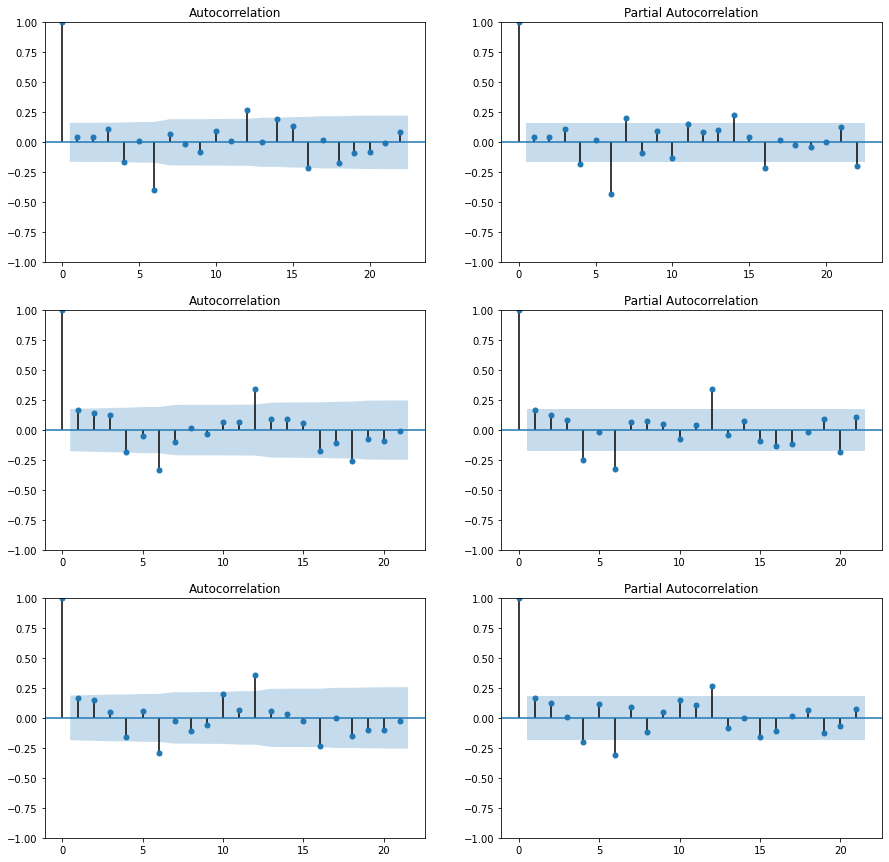

In [ ]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
plot_acf(diff_pos,ax=ax[0,0])
plot_pacf(diff_pos,ax=ax[0,1])
plot_acf(diff_neu,ax=ax[1,0])
plot_pacf(diff_neu,ax=ax[1,1])
plot_acf(diff_neg,ax=ax[2,0])
plot_pacf(diff_neg,ax=ax[2,1])
plt.show()

### POSITIVE SENTIMENT

**SARIMA**

In [ ]:
# sarima_a={}
# sarima_l={}
# for p in range(1,5):
#   for d in range(1,3):
#     for q in range(1,5):
#         m1 = SARIMAX(train_pos,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         sarima_a[f'({p},{d},{q})']=m1.aic
#         sarima_l[f'({p},{d},{q})']=m1.llf
# min(sarima_a,key=sarima_a.get),max(sarima_l,key=sarima_l.get)

In [ ]:
sarima = SARIMAX(train_pos,order=(1,2,1),seasonal_order=(1,2,1,12)).fit()
sarima_train_pred = sarima.predict(0,(len(train_pos)-1))
sarima_test_pred = sarima.predict(len(train_pos),(len(train_pos)+len(test_pos)-1))
print(sarima.summary())
ljung3 = sm.stats.acorr_ljungbox(sarima.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung3}')

                                     SARIMAX Results                                      
Dep. Variable:                          productID   No. Observations:                   48
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 12)   Log Likelihood                -180.231
Date:                            Tue, 21 Jun 2022   AIC                            370.462
Time:                                    14:14:10   BIC                            375.918
Sample:                                01-31-2010   HQIC                           371.748
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2890      0.421      0.686      0.493      -0.537       1.115
ma.L1         -0.9982     52.131   

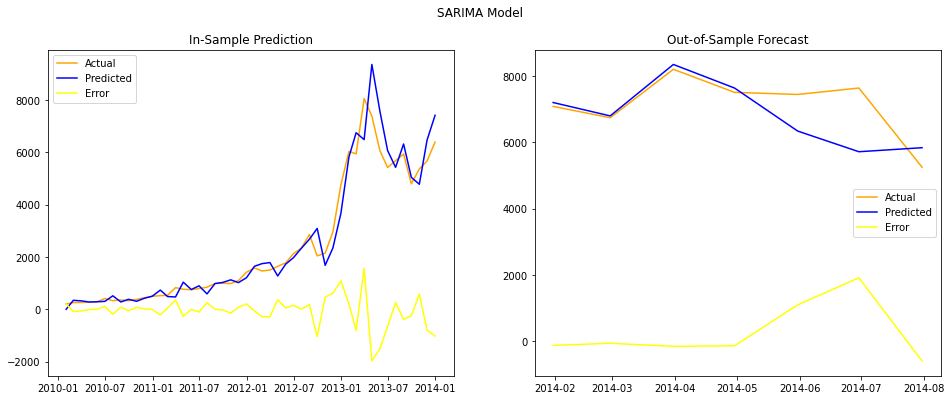

In [ ]:
saim_train = pd.DataFrame({'Actual':train_pos,'Predicted':sarima_train_pred})
saim_test = pd.DataFrame({'Actual':test_pos,'Predicted':sarima_test_pred})
saim_train['Error']=saim_train['Actual']-saim_train['Predicted']
saim_test['Error']=saim_test['Actual']-saim_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saim_train['Actual'],color='orange',label='Actual')
plt.plot(saim_train['Predicted'],color='blue',label='Predicted')
plt.plot(saim_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(saim_test['Actual'],color='orange',label='Actual')
plt.plot(saim_test['Predicted'],color='blue',label='Predicted')
plt.plot(saim_test['Error'],color='yellow',label='Error')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMA Model');

In [ ]:
np.sqrt(mean_squared_error(saim_test.Actual,saim_test.Predicted))

869.9808119395071

In [ ]:
np.sqrt(mean_squared_error(saim_train.Actual,saim_train.Predicted))

573.6317601978791

Positive forecast

In [ ]:
fortp=sarima.forecast(len(test_pos)+21)

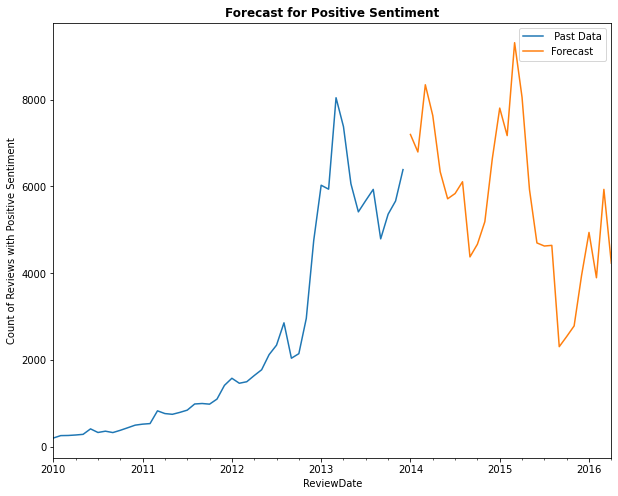

In [ ]:
train_pos.plot(figsize=(10,8),legend=True,sharex=True,label=' Past Data')
# test_pos.plot(figsize=(10,8),legend=True,sharex=True)
fortp.plot(legend=True,label='Forecast')
plt.ylabel('Count of Reviews with Positive Sentiment')
plt.title('Forecast for Positive Sentiment',fontweight='bold')
plt.show()

In [ ]:
plt.ylabel

<function matplotlib.pyplot.ylabel>

### Negative Sentiment

In [ ]:
train_neg=negative1[(negative1.index.year >= 2010) & (negative1.index.year <= 2013)]
test_neg=negative1[(negative1.index.year > 2013)]

In [ ]:
# sarima_a1={}
# sarima_l1={}
# for p in range(1,5):
#   for d in range(1,3):
#     for q in range(1,5):
#         m1 = SARIMAX(train_neg,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         sarima_a1[f'({p},{d},{q})']=m1.aic
#         sarima_l1[f'({p},{d},{q})']=m1.llf
# min(sarima_a1,key=sarima_a1.get),max(sarima_l1,key=sarima_l1.get)

In [ ]:
sarima11 = SARIMAX(train_neg,order=(1,2,1),seasonal_order=(3,2,4,12)).fit()
sarima11_train_pred = sarima11.predict(0,(len(train_neg)-1))
sarima11_test_pred = sarima11.predict(len(train_neg),(len(train_neg)+len(test_neg)-1))
# print(sarima11.summary())
ljung11 = sm.stats.acorr_ljungbox(sarima11.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung11}')

LJung Box Test Value : [0.37030632]


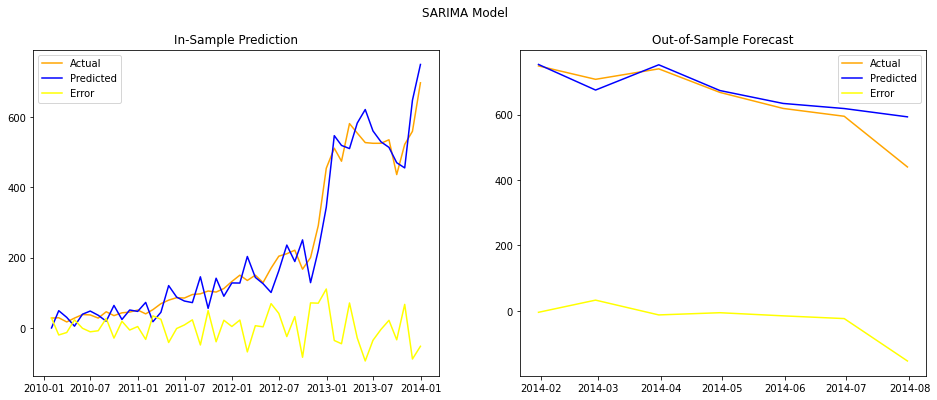

In [ ]:
saim11_train = pd.DataFrame({'Actual':train_neg,'Predicted':sarima11_train_pred})
saim11_test = pd.DataFrame({'Actual':test_neg,'Predicted':sarima11_test_pred})
saim11_train['Error']=saim11_train['Actual']-saim11_train['Predicted']
saim11_test['Error']=saim11_test['Actual']-saim11_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saim11_train['Actual'],color='orange',label='Actual')
plt.plot(saim11_train['Predicted'],color='blue',label='Predicted')
plt.plot(saim11_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(saim11_test['Actual'],color='orange',label='Actual')
plt.plot(saim11_test['Predicted'],color='blue',label='Predicted')
plt.plot(saim11_test['Error'],color='yellow',label='Error')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMA Model');

In [ ]:
np.sqrt(mean_squared_error(saim11_test.Actual,saim11_test.Predicted))

60.432668861435815

In [ ]:
np.sqrt(mean_squared_error(saim11_train.Actual,saim11_train.Predicted))

44.354006578499295

Negative Forecast

In [ ]:
fortng=sarima11.forecast(len(test_neg)+20)

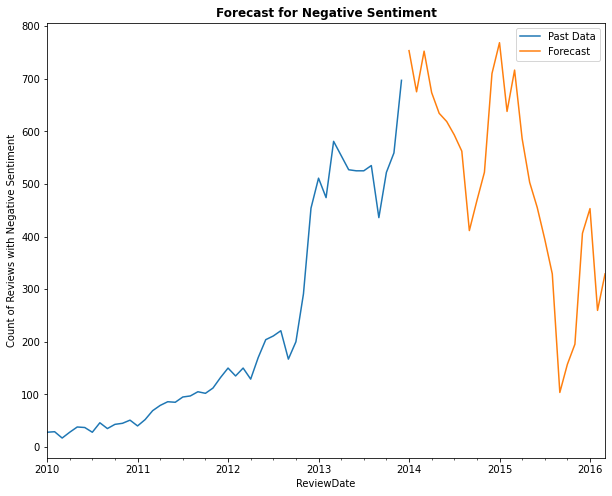

In [ ]:
train_neg.plot(figsize=(10,8),legend=True,sharex=True,label='Past Data')
# test_neg.plot(figsize=(10,8),legend=True,sharex=True)
fortng.plot(legend=True,label='Forecast')
plt.ylabel('Count of Reviews with Negative Sentiment')
plt.title('Forecast for Negative Sentiment',fontweight='bold')
plt.show()

### Neutral Sentiment

In [ ]:
train_neu=neutral1[(neutral1.index.year >= 2010) & (neutral1.index.year <= 2013)]
test_neu=neutral1[(neutral1.index.year > 2013)]

In [ ]:
# sarima_a12={}
# sarima_l12={}
# for p in range(1,5):
#   for d in range(0,1):
#     for q in range(1,5):
#         m1 = SARIMAX(train_neu,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         sarima_a12[f'({p},{d},{q})']=m1.aic
#         sarima_l12[f'({p},{d},{q})']=m1.llf
# min(sarima_a12,key=sarima_a12.get),max(sarima_l12,key=sarima_l12.get)

In [ ]:
sarima12 = SARIMAX(train_neu,order=(1,0,1),seasonal_order=(1,0,1,12)).fit()
sarima12_train_pred = sarima12.predict(0,(len(train_neu)-1))
sarima12_test_pred = sarima12.predict(len(train_neu),(len(train_neu)+len(test_neu)-1))
# print(sarima11.summary())
ljung12 = sm.stats.acorr_ljungbox(sarima12.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung12}')

LJung Box Test Value : [0.9580362]


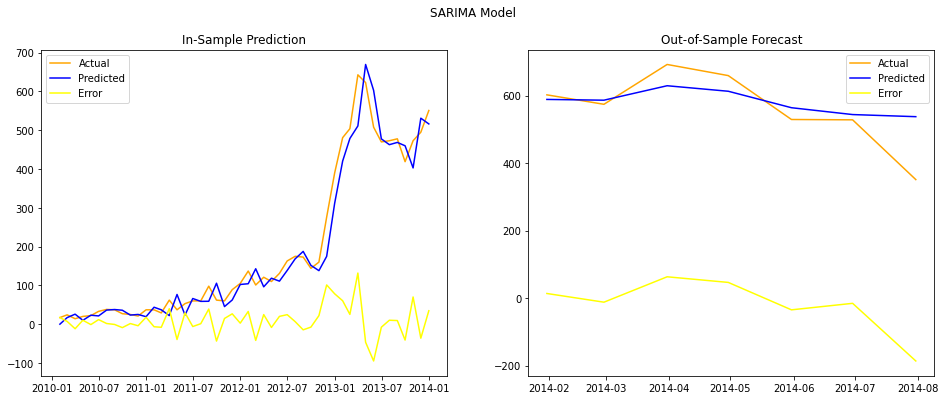

In [ ]:
saim12_train = pd.DataFrame({'Actual':train_neu,'Predicted':sarima12_train_pred})
saim12_test = pd.DataFrame({'Actual':test_neu,'Predicted':sarima12_test_pred})
saim12_train['Error']=saim12_train['Actual']-saim12_train['Predicted']
saim12_test['Error']=saim12_test['Actual']-saim12_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saim12_train['Actual'],color='orange',label='Actual')
plt.plot(saim12_train['Predicted'],color='blue',label='Predicted')
plt.plot(saim12_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(saim12_test['Actual'],color='orange',label='Actual')
plt.plot(saim12_test['Predicted'],color='blue',label='Predicted')
plt.plot(saim12_test['Error'],color='yellow',label='Error')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMA Model');

In [ ]:
np.sqrt(mean_squared_error(saim12_test.Actual,saim12_test.Predicted))

78.04692353523271

In [ ]:
np.sqrt(mean_squared_error(saim12_train.Actual,saim12_train.Predicted))

39.143375497340294

Neutral Forecast

In [ ]:
fortne=sarima12.forecast(len(test_neu)+21)

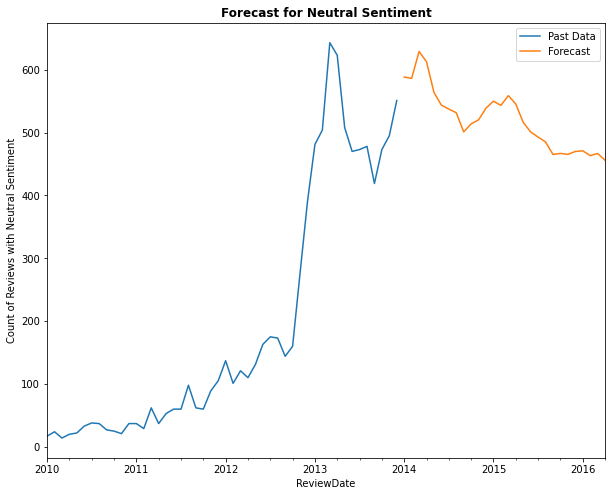

In [ ]:
train_neu.plot(figsize=(10,8),legend=True,sharex=True,label='Past Data')
# test_neu.plot(figsize=(10,8),legend=True,sharex=True)
fortne.plot(legend=True,label='Forecast')
plt.ylabel('Count of Reviews with Neutral Sentiment')
plt.title('Forecast for Neutral Sentiment',fontweight='bold')
plt.show()

## Using Count (Feature Method) for **Clothes-Shoes-Jewelry** Dataset

In [ ]:
positivec=trial[(trial['pred_sentiment']=='Positive') & (trial['category']=='Clothing-Shoes-Jewelry')]
negativec=trial[(trial['pred_sentiment']=='Negative') & (trial['category']=='Clothing-Shoes-Jewelry')]
neutralc=trial[(trial['pred_sentiment']=='Neutral') & (trial['category']=='Clothing-Shoes-Jewelry')]

In [ ]:
def checkStationarity(test):
    pvalue = adfuller(test)[1]
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
    return(msg)

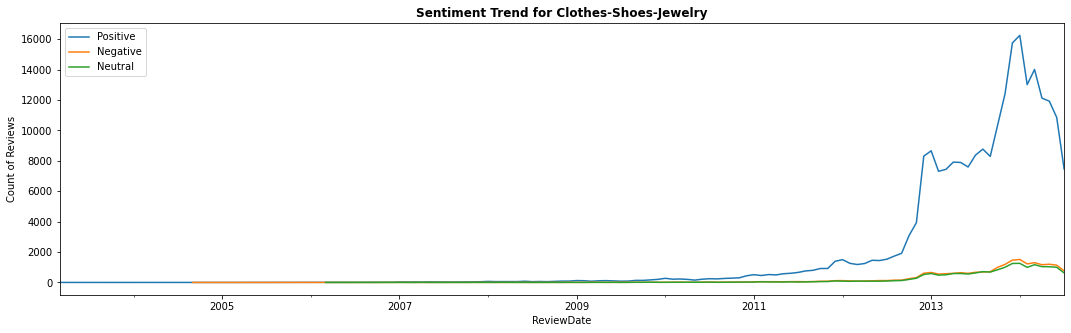

In [ ]:
positivec['productID'].resample('M').count().plot(figsize=(18,5),label='Positive')
negativec['productID'].resample('M').count().plot(figsize=(18,5),label='Negative')
neutralc['productID'].resample('M').count().plot(figsize=(18,5),label='Neutral')
plt.legend()
plt.title('Sentiment Trend for Clothes-Shoes-Jewelry',fontweight='bold')
plt.ylabel('Count of Reviews');

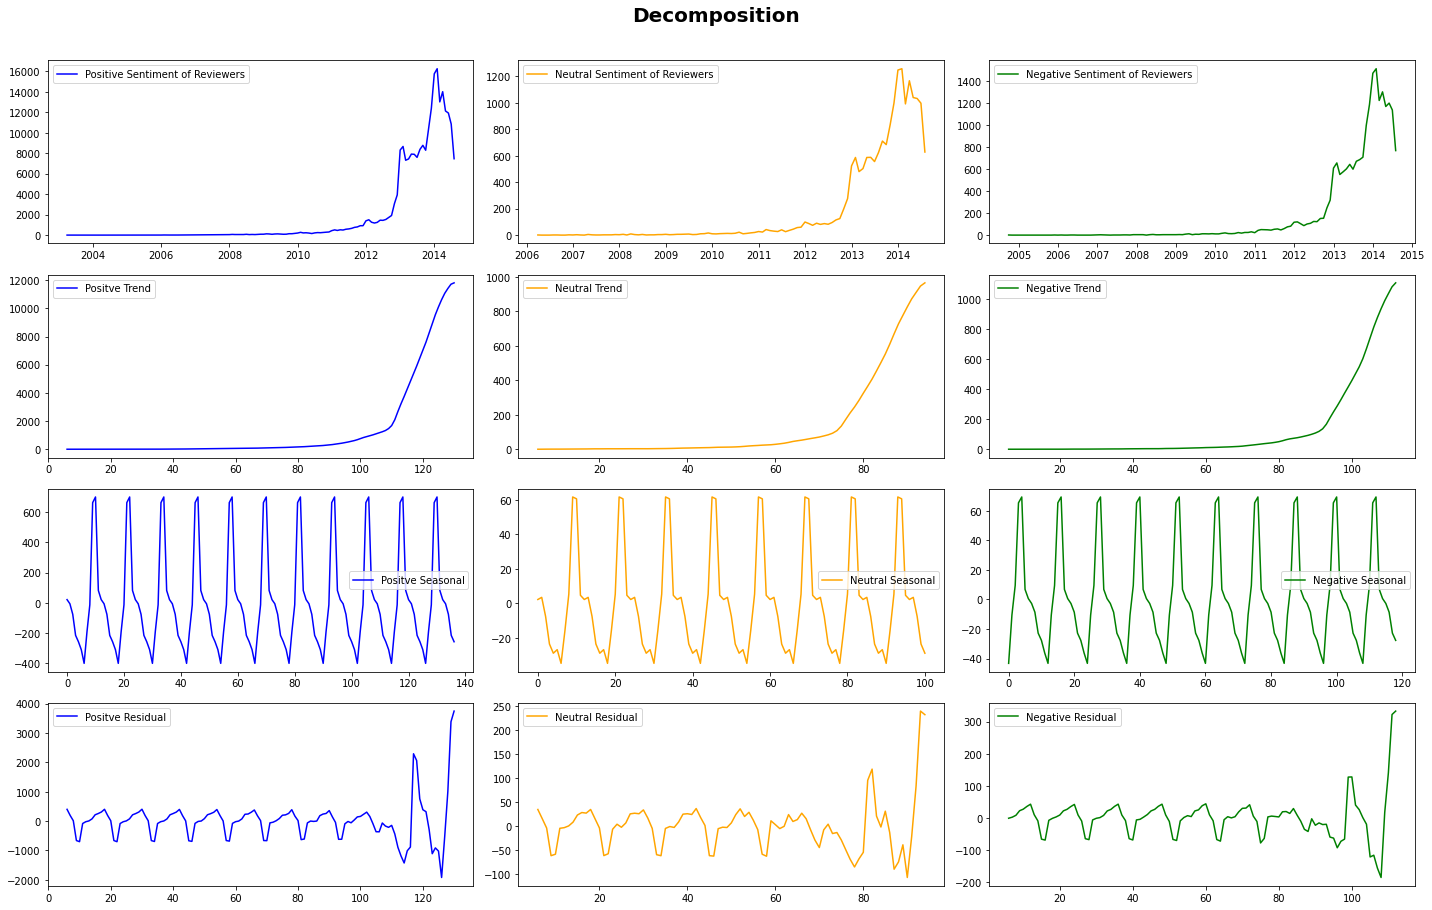

In [ ]:
# Decomposition plot for predicted data using Features
decomposition_p=seasonal_decompose(np.asarray(positivec['productID'].resample('M').count()), period=12)
d_trend_p=decomposition_p.trend
d_seasonal_p=decomposition_p.seasonal
d_residual_p=decomposition_p.resid
decomposition=seasonal_decompose(np.asarray(neutralc['productID'].resample('M').count()), period=12)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid
decomposition_n=seasonal_decompose(np.asarray(negativec['productID'].resample('M').count()), period=12)
d_trend_n=decomposition_n.trend
d_seasonal_n=decomposition_n.seasonal
d_residual_n=decomposition_n.resid
# plotting all the 4 graphs
fig,ax = plt.subplots(4,3,figsize=(20,12))
plt.subplot(4,3,1)
plt.plot(positivec['productID'].resample('M').count(),label='Positive Sentiment of Reviewers',color='b')
plt.legend(loc='best')
plt.subplot(4,3,2)
plt.plot(neutralc['productID'].resample('M').count(),label='Neutral Sentiment of Reviewers',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,3)
plt.plot(negativec['productID'].resample('M').count(),label='Negative Sentiment of Reviewers',color='g')
plt.legend(loc='best')
plt.subplot(4,3,4)
plt.plot(d_trend_p,label='Positve Trend',color='b')
plt.legend(loc='best')
plt.subplot(4,3,5)
plt.plot(d_trend,label='Neutral Trend',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,6)
plt.plot(d_trend_n,label='Negative Trend',color='g')
plt.legend(loc='best')
plt.subplot(4,3,7)
plt.plot(d_seasonal_p,label='Positve Seasonal',color='b')
plt.legend(loc='best')
plt.subplot(4,3,8)
plt.plot(d_seasonal,label='Neutral Seasonal',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,9)
plt.plot(d_seasonal_n,label='Negative Seasonal',color='g')
plt.legend(loc='best')
plt.subplot(4,3,10)
plt.plot(d_residual_p,label='Positve Residual',color='b')
plt.legend(loc='best')
plt.subplot(4,3,11)
plt.plot(d_residual,label='Neutral Residual',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,12)
plt.plot(d_residual_n,label='Negative Residual',color='g')
plt.legend(loc='best')
plt.suptitle('Decomposition',x=0.5,y=1.05,fontweight='bold',fontsize=20)
plt.tight_layout()

Stationarity Check

In [ ]:
positivec1=positivec['productID'].resample('M').count()
negativec1=negativec['productID'].resample('M').count()
neutralc1=neutralc['productID'].resample('M').count()

In [ ]:
checkStationarity(positivec1.iloc[round(len(positivec1)*0.7):])

'p-value=0.7033762678869022. Data is not stationary'

In [ ]:
trainc_pos=positivec1[(positivec1.index.year >= 2010) & (positivec1.index.year <= 2013)]
testc_pos=positivec1[(positivec1.index.year > 2013)]

In [ ]:
checkStationarity(trainc_pos)

'p-value=1.0. Data is not stationary'

In [ ]:
checkStationarity(testc_pos)

'p-value=0.9980402731161341. Data is not stationary'

In [ ]:
checkStationarity(negativec1.iloc[round(len(negativec1)*0.7):])

'p-value=0.9943628691554592. Data is not stationary'

In [ ]:
checkStationarity(neutralc1.iloc[round(len(neutralc1)*0.7):])

'p-value=0.9216528489645015. Data is not stationary'

In [ ]:
diffc_pos = positivec1- positivec1.shift()
diffc_neg = negativec1- negativec1.shift()
diffc_neu = neutralc1 - neutralc1.shift()
diffc_pos.dropna(inplace=True)
diffc_neg.dropna(inplace=True)
diffc_neu.dropna(inplace=True)
diffc_pos.head(3),diffc_neg.head(3),diffc_neu.head(3)

(ReviewDate
 2003-04-30   -1.0
 2003-05-31    0.0
 2003-06-30    0.0
 Freq: M, Name: productID, dtype: float64, ReviewDate
 2004-10-31   -1.0
 2004-11-30    0.0
 2004-12-31    0.0
 Freq: M, Name: productID, dtype: float64, ReviewDate
 2006-04-30   -1.0
 2006-05-31    0.0
 2006-06-30    0.0
 Freq: M, Name: productID, dtype: float64)

In [ ]:
checkStationarity(diffc_pos.iloc[round(len(diffc_pos)*0.7):])

'p-value=0.00030233033625968434. Data is stationary'

In [ ]:
checkStationarity(diffc_neg.iloc[round(len(diffc_neg)*0.7):])

'p-value=0.03308557257665251. Data is stationary'

In [ ]:
checkStationarity(diffc_neu.iloc[round(len(diffc_neu)*0.7):])

'p-value=0.05231232119177193. Data is not stationary'

In [ ]:
diffc_neu=diffc_neu-diffc_neu.shift()
diffc_neu.dropna(inplace=True)

In [ ]:
checkStationarity(diffc_neu.iloc[round(len(diffc_neu)*0.7):])

'p-value=0.046605926645420424. Data is stationary'

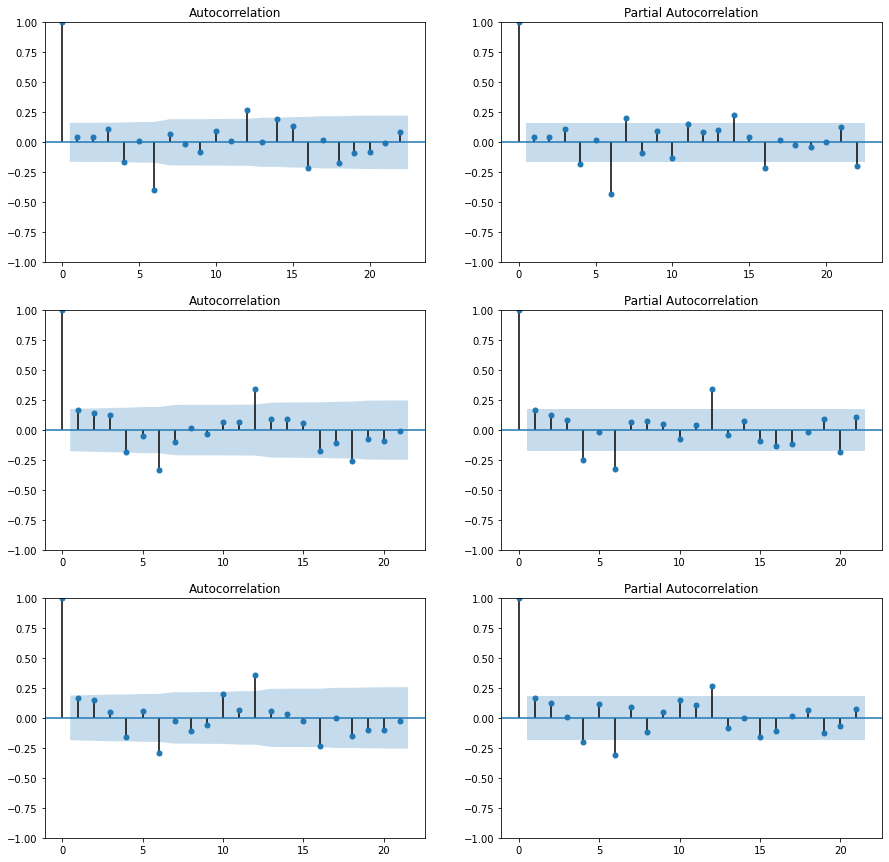

In [ ]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
plot_acf(diff_pos,ax=ax[0,0])
plot_pacf(diff_pos,ax=ax[0,1])
plot_acf(diff_neu,ax=ax[1,0])
plot_pacf(diff_neu,ax=ax[1,1])
plot_acf(diff_neg,ax=ax[2,0])
plot_pacf(diff_neg,ax=ax[2,1])
plt.show()

### POSITIVE SENTIMENT

**SARIMA**

In [ ]:
# sarimac_a={}
# sarimac_l={}
# for p in range(1,5):
#   for d in range(0,1):
#     for q in range(1,5):
#         m1 = SARIMAX(trainc_pos,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         sarimac_a[f'({p},{d},{q})']=m1.aic
#         sarimac_l[f'({p},{d},{q})']=m1.llf
# min(sarimac_a,key=sarimac_a.get),max(sarimac_l,key=sarimac_l.get)

In [ ]:
sarimac = SARIMAX(trainc_pos,order=(1,0,1),seasonal_order=(1,0,1,12)).fit()
sarimac_train_pred = sarimac.predict(0,(len(trainc_pos)-1))
sarimac_test_pred = sarimac.predict(len(trainc_pos),(len(trainc_pos)+len(testc_pos)-1))
print(sarimac.summary())
ljung3 = sm.stats.acorr_ljungbox(sarimac.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung3}')

                                     SARIMAX Results                                      
Dep. Variable:                          productID   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -388.450
Date:                            Tue, 21 Jun 2022   AIC                            786.899
Time:                                    14:14:26   BIC                            796.255
Sample:                                01-31-2010   HQIC                           790.435
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9864      0.029     33.862      0.000       0.929       1.044
ma.L1          0.3524      0.112   

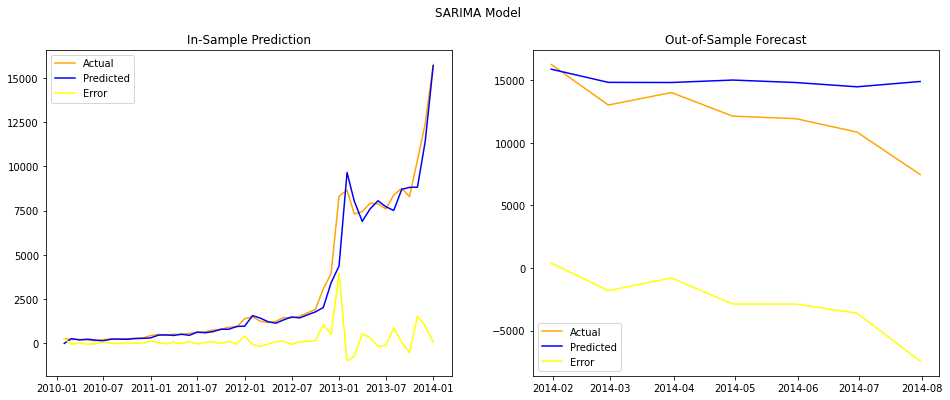

In [ ]:
saimc_train = pd.DataFrame({'Actual':trainc_pos,'Predicted':sarimac_train_pred})
saimc_test = pd.DataFrame({'Actual':testc_pos,'Predicted':sarimac_test_pred})
saimc_train['Error']=saimc_train['Actual']-saimc_train['Predicted']
saimc_test['Error']=saimc_test['Actual']-saimc_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saimc_train['Actual'],color='orange',label='Actual')
plt.plot(saimc_train['Predicted'],color='blue',label='Predicted')
plt.plot(saimc_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(saimc_test['Actual'],color='orange',label='Actual')
plt.plot(saimc_test['Predicted'],color='blue',label='Predicted')
plt.plot(saimc_test['Error'],color='yellow',label='Error')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMA Model');

In [ ]:
np.sqrt(mean_squared_error(saimc_test.Actual,saimc_test.Predicted))

3566.9742753527853

In [ ]:
np.sqrt(mean_squared_error(saimc_train.Actual,saimc_train.Predicted))

702.2070541319129

Positive forecast

In [ ]:
fortpc=sarimac.forecast(len(testc_pos)+21)

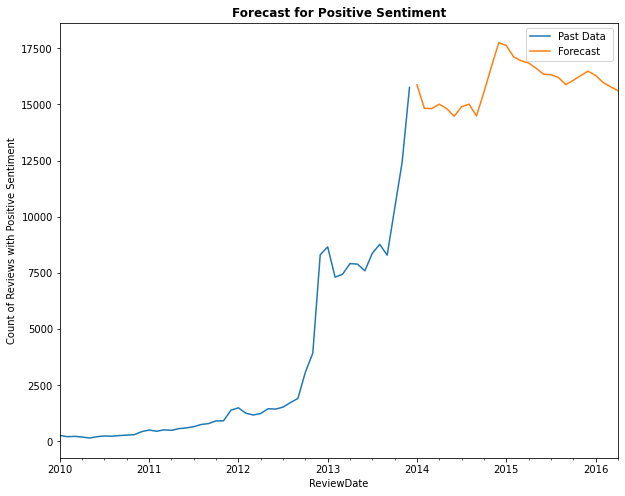

In [ ]:
trainc_pos.plot(figsize=(10,8),legend=True,sharex=True,label='Past Data ')
# testc_pos.plot(figsize=(10,8),legend=True,sharex=True,label='Past Data (Test)')
fortpc.plot(legend=True,label='Forecast')
plt.ylabel('Count of Reviews with Positive Sentiment')
plt.title('Forecast for Positive Sentiment',fontweight='bold')
plt.show()

### Negative Sentiment

In [ ]:
trainc_neg=negativec1[(negativec1.index.year >= 2010) & (negativec1.index.year <= 2013)]
testc_neg=negativec1[(negativec1.index.year > 2013)]

In [ ]:
# sarimac_a1={}
# sarimac_l1={}
# for p in range(1,5):
#   for d in range(0,3):
#     for q in range(1,5):
#         m1 = SARIMAX(train_neg,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         sarimac_a1[f'({p},{d},{q})']=m1.aic
#         sarimac_l1[f'({p},{d},{q})']=m1.llf
# min(sarimac_a1,key=sarimac_a1.get),max(sarimac_l1,key=sarimac_l1.get)

In [ ]:
sarima1c1 = SARIMAX(trainc_neg,order=(1,2,1),seasonal_order=(1,2,1,12)).fit()
sarima1c1_train_pred = sarima1c1.predict(0,(len(trainc_neg)-1))
sarima1c1_test_pred = sarima1c1.predict(len(trainc_neg),(len(trainc_neg)+len(testc_neg)-1))
# print(sarima11.summary())
ljung11 = sm.stats.acorr_ljungbox(sarima1c1.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung11}')

LJung Box Test Value : [0.63380671]


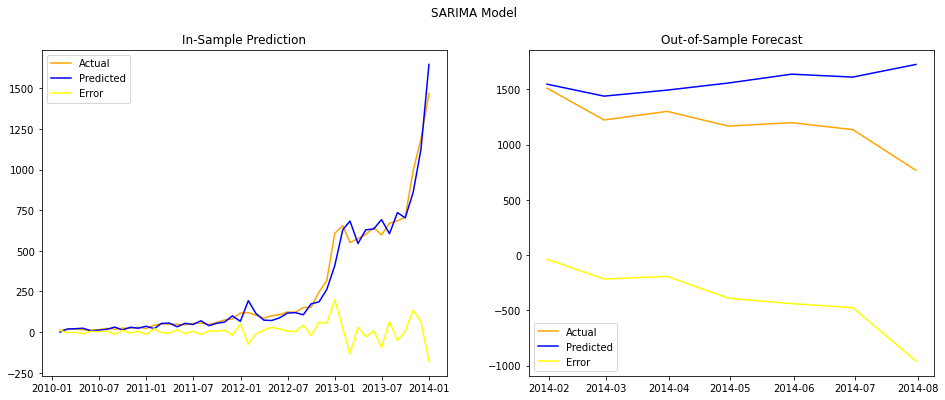

In [ ]:
saim1c1_train = pd.DataFrame({'Actual':trainc_neg,'Predicted':sarima1c1_train_pred})
saim1c1_test = pd.DataFrame({'Actual':testc_neg,'Predicted':sarima1c1_test_pred})
saim1c1_train['Error']=saim1c1_train['Actual']-saim1c1_train['Predicted']
saim1c1_test['Error']=saim1c1_test['Actual']-saim1c1_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saim1c1_train['Actual'],color='orange',label='Actual')
plt.plot(saim1c1_train['Predicted'],color='blue',label='Predicted')
plt.plot(saim1c1_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(saim1c1_test['Actual'],color='orange',label='Actual')
plt.plot(saim1c1_test['Predicted'],color='blue',label='Predicted')
plt.plot(saim1c1_test['Error'],color='yellow',label='Error')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMA Model');

In [ ]:
np.sqrt(mean_squared_error(saim1c1_test.Actual,saim1c1_test.Predicted))

473.7407070016216

In [ ]:
np.sqrt(mean_squared_error(saim1c1_train.Actual,saim1c1_train.Predicted))

55.843846763682635

Negative Forecast

In [ ]:
fortcng=sarima1c1.forecast(len(testc_neg)+20)

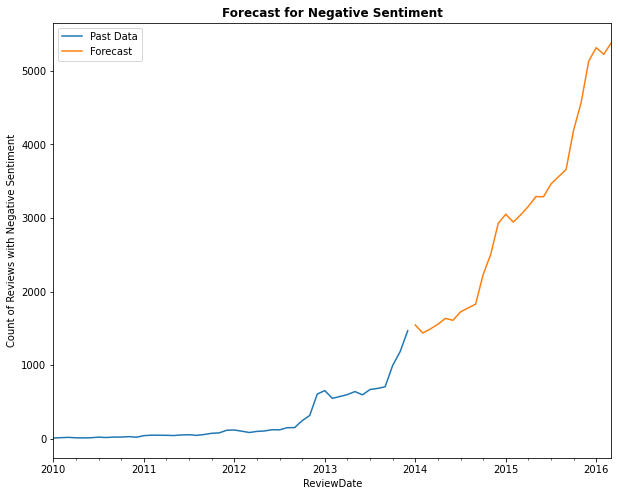

In [ ]:
trainc_neg.plot(figsize=(10,8),legend=True,sharex=True,label='Past Data')
# testc_neg.plot(figsize=(10,8),legend=True,sharex=True)
fortcng.plot(legend=True,label='Forecast')
plt.ylabel('Count of Reviews with Negative Sentiment')
plt.title('Forecast for Negative Sentiment',fontweight='bold')
plt.show()

### Neutral Sentiment

In [ ]:
trainc_neu=neutralc1[(neutralc1.index.year >= 2010) & (neutralc1.index.year <= 2013)]
testc_neu=neutralc1[(neutralc1.index.year > 2013)]

In [ ]:
# sarimac_a12={}
# sarimac_l12={}
# for p in range(1,5):
#   for d in range(0,1):
#     for q in range(1,5):
#         m1 = SARIMAX(trainc_neu,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         sarimac_a12[f'({p},{d},{q})']=m1.aic
#         sarimac_l12[f'({p},{d},{q})']=m1.llf
# min(sarimac_a12,key=sarimac_a12.get),max(sarimac_l12,key=sarimac_l12.get)

In [ ]:
sarimac12 = SARIMAX(trainc_neu,order=(1,0,1),seasonal_order=(1,0,1,12)).fit()
sarimac12_train_pred = sarimac12.predict(0,(len(trainc_neu)-1))
sarimac12_test_pred = sarimac12.predict(len(trainc_neu),(len(trainc_neu)+len(testc_neu)-1))
# print(sarima11.summary())
ljung12 = sm.stats.acorr_ljungbox(sarimac12.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung12}')

LJung Box Test Value : [0.4954624]


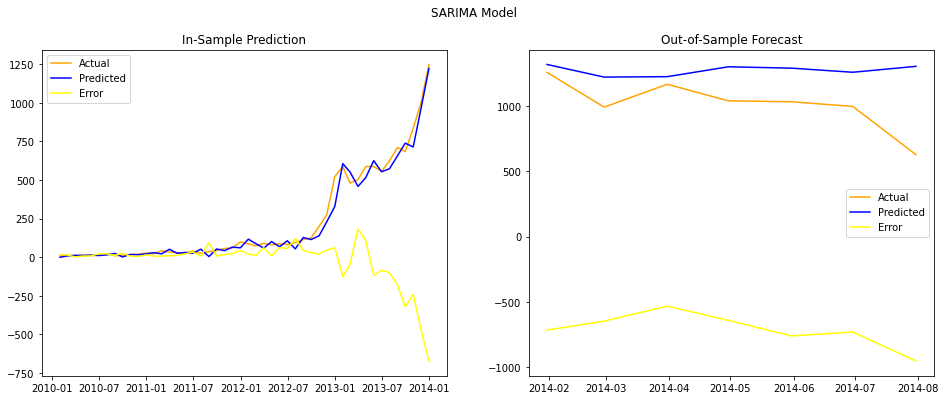

In [ ]:
saimc12_train = pd.DataFrame({'Actual':trainc_neu,'Predicted':sarimac12_train_pred})
saimc12_test = pd.DataFrame({'Actual':testc_neu,'Predicted':sarimac12_test_pred})
saimc12_train['Error']=saim12_train['Actual']-saimc12_train['Predicted']
saimc12_test['Error']=saim12_test['Actual']-saimc12_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saimc12_train['Actual'],color='orange',label='Actual')
plt.plot(saimc12_train['Predicted'],color='blue',label='Predicted')
plt.plot(saimc12_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(saimc12_test['Actual'],color='orange',label='Actual')
plt.plot(saimc12_test['Predicted'],color='blue',label='Predicted')
plt.plot(saimc12_test['Error'],color='yellow',label='Error')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMA Model');

In [ ]:
np.sqrt(mean_squared_error(saimc12_test.Actual,saimc12_test.Predicted))

320.705865997609

In [ ]:
np.sqrt(mean_squared_error(saimc12_train.Actual,saimc12_train.Predicted))

44.03968370378673

Neutral Forecast

In [ ]:
fortcne=sarimac12.forecast(len(testc_neu)+21)

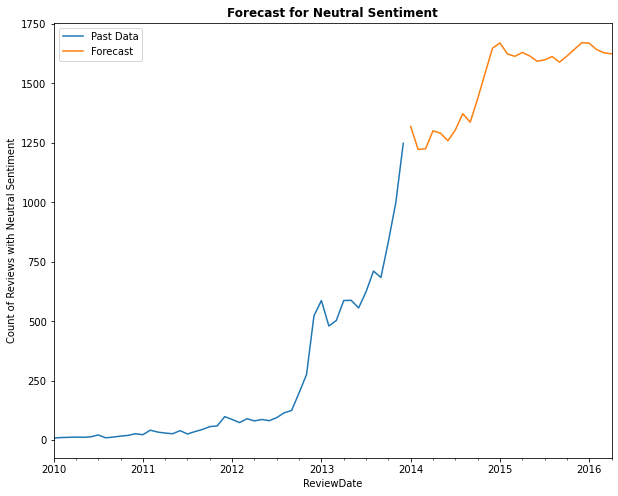

In [ ]:
trainc_neu.plot(figsize=(10,8),legend=True,sharex=True,label='Past Data')
# testc_neu.plot(figsize=(10,8),legend=True,sharex=True)
fortcne.plot(legend=True,label='Forecast')
plt.ylabel('Count of Reviews with Neutral Sentiment')
plt.title('Forecast for Neutral Sentiment',fontweight='bold')
plt.show()

In [ ]:
df=trial[(trial['productID']=='B007RTR9DS')]
df.shape

(173, 11)

In [ ]:
# df['reviewerID'].resample('M').count()

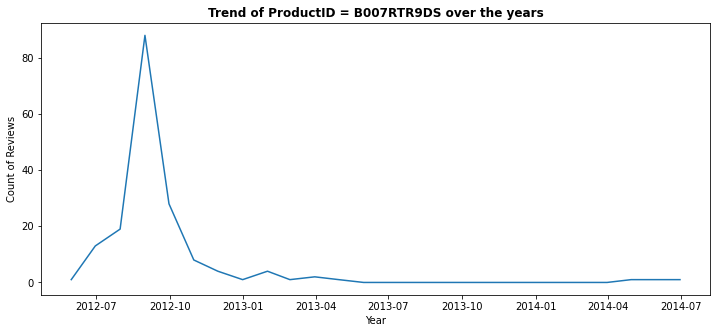

In [ ]:
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count())
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B007RTR9DS over the years',fontweight='bold');

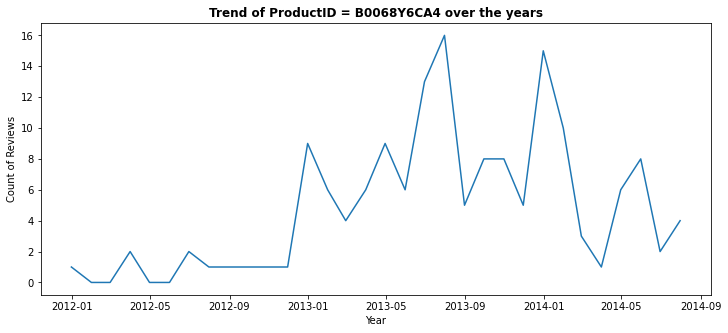

In [ ]:
df=trial[(trial['productID']=='B0068Y6CA4')]
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count())
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B0068Y6CA4 over the years',fontweight='bold');

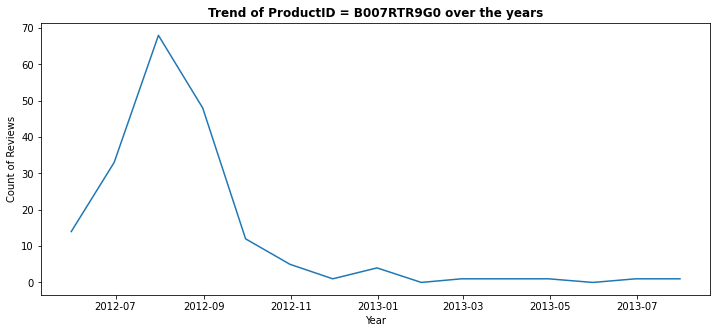

In [ ]:
df=trial[(trial['productID']=='B007RTR9G0')]
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count())
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B007RTR9G0 over the years',fontweight='bold');

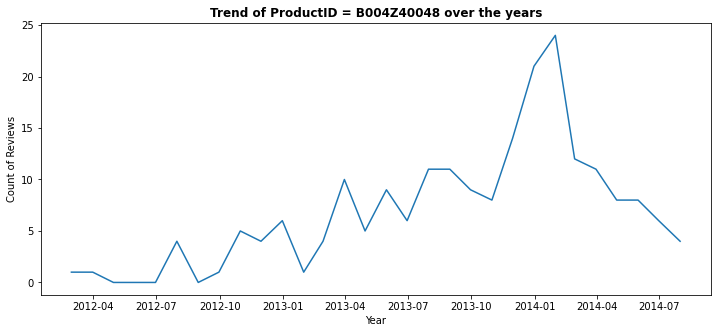

In [ ]:
df=trial[(trial['productID']=='B004Z40048')]
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count())
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B004Z40048 over the years',fontweight='bold');

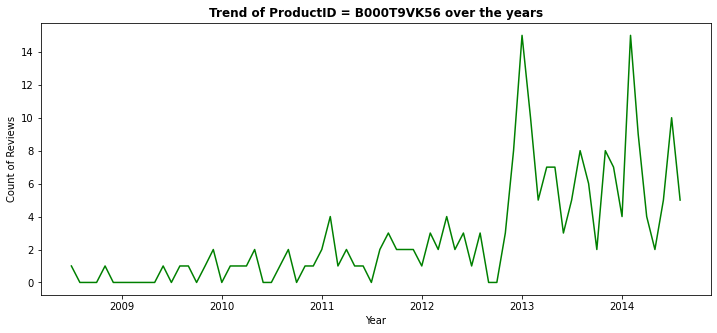

In [ ]:
df=trial[(trial['productID']=='B000T9VK56')]
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count(),color='g')
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B000T9VK56 over the years',fontweight='bold');

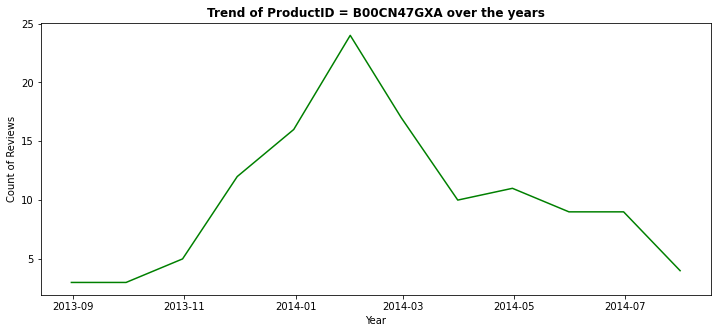

In [ ]:
df=trial[(trial['productID']=='B00CN47GXA')]
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count(),color='g')
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B00CN47GXA over the years',fontweight='bold');

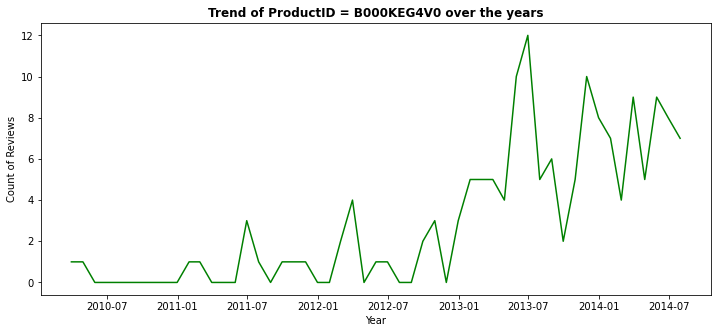

In [ ]:
df=trial[(trial['productID']=='B000KEG4V0')]
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count(),color='g')
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B000KEG4V0 over the years',fontweight='bold');

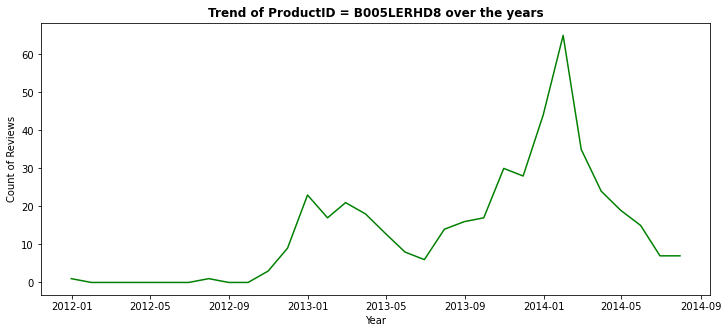

In [ ]:
df=trial[(trial['productID']=='B005LERHD8')]
plt.subplots(figsize=(12,5))
plt.plot(df['reviewerID'].resample('M').count(),color='g')
plt.ylabel('Count of Reviews')
plt.xlabel('Year')
plt.title('Trend of ProductID = B005LERHD8 over the years',fontweight='bold');

In [ ]:
negative.head(1)

,reviewerID,productID,helpful,overall,category,review,pro_review,sentiment,pred_sentiment,polarity,blob_sentiment
ReviewDate,,,,,,,,,,,
2005-04-13,A1X2LENOF84LCQ,B0000CC64W,0.826667,4,Beauty,I have tried so many products to just be total...,tried product totally disappointed work line e...,Positive,Negative,-0.089583,Negative


## Rule Base(TEST MODEL)

In [ ]:
positive_blob=trial[(trial['pred_sentiment']=='Positive') & (trial['category']=='Clothing-Shoes-Jewelry')]
negative_blob=trial[(trial['pred_sentiment']=='Negative')& (trial['category']=='Clothing-Shoes-Jewelry')]
neutral_blob=trial[(trial['pred_sentiment']=='Neutral') & (trial['category']=='Clothing-Shoes-Jewelry')]

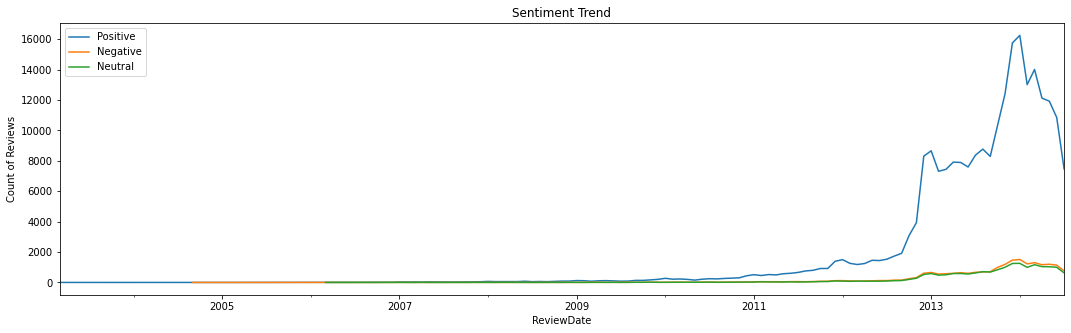

In [ ]:
positive_blob['productID'].resample('M').count().plot(figsize=(18,5),label='Positive')
negative_blob['productID'].resample('M').count().plot(figsize=(18,5),label='Negative')
neutral_blob['productID'].resample('M').count().plot(figsize=(18,5),label='Neutral')
plt.legend()
plt.title('Sentiment Trend')
plt.ylabel('Count of Reviews');

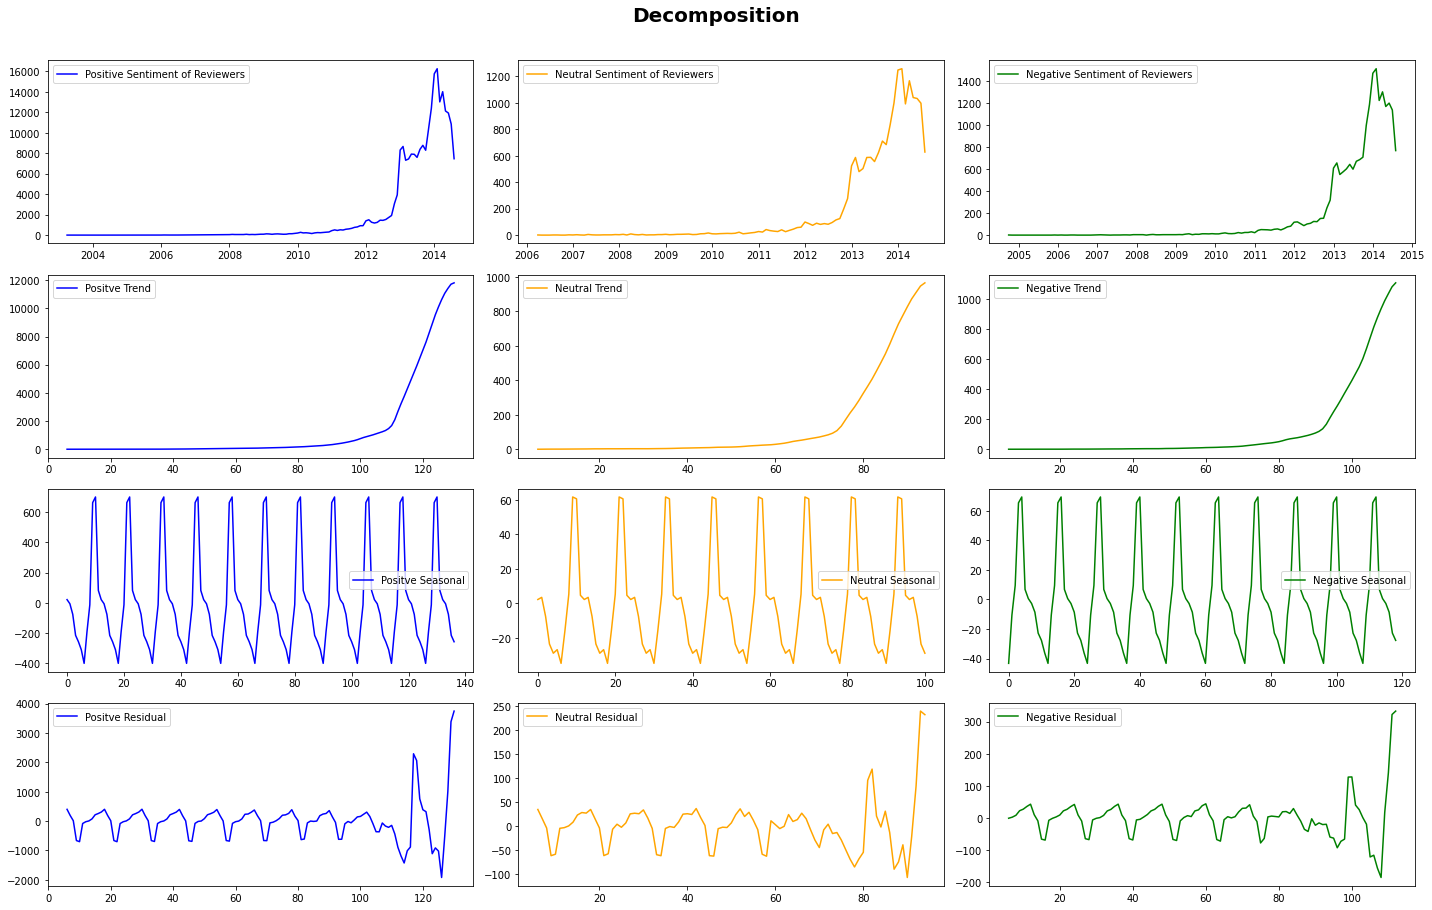

In [ ]:
# Decomposition plot for predicted data using Blob
decomposition_p=seasonal_decompose(np.asarray(positive_blob['productID'].resample('M').count()), period=12)
d_trend_p=decomposition_p.trend
d_seasonal_p=decomposition_p.seasonal
d_residual_p=decomposition_p.resid
decomposition=seasonal_decompose(np.asarray(neutral_blob['productID'].resample('M').count()), period=12)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid
decomposition_n=seasonal_decompose(np.asarray(negative_blob['productID'].resample('M').count()), period=12)
d_trend_n=decomposition_n.trend
d_seasonal_n=decomposition_n.seasonal
d_residual_n=decomposition_n.resid
# plotting all the 4 graphs
fig,ax = plt.subplots(4,3,figsize=(20,12))
plt.subplot(4,3,1)
plt.plot(positive_blob['productID'].resample('M').count(),label='Positive Sentiment of Reviewers',color='b')
plt.legend(loc='best')
plt.subplot(4,3,2)
plt.plot(neutral_blob['productID'].resample('M').count(),label='Neutral Sentiment of Reviewers',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,3)
plt.plot(negative_blob['productID'].resample('M').count(),label='Negative Sentiment of Reviewers',color='g')
plt.legend(loc='best')
plt.subplot(4,3,4)
plt.plot(d_trend_p,label='Positve Trend',color='b')
plt.legend(loc='best')
plt.subplot(4,3,5)
plt.plot(d_trend,label='Neutral Trend',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,6)
plt.plot(d_trend_n,label='Negative Trend',color='g')
plt.legend(loc='best')
plt.subplot(4,3,7)
plt.plot(d_seasonal_p,label='Positve Seasonal',color='b')
plt.legend(loc='best')
plt.subplot(4,3,8)
plt.plot(d_seasonal,label='Neutral Seasonal',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,9)
plt.plot(d_seasonal_n,label='Negative Seasonal',color='g')
plt.legend(loc='best')
plt.subplot(4,3,10)
plt.plot(d_residual_p,label='Positve Residual',color='b')
plt.legend(loc='best')
plt.subplot(4,3,11)
plt.plot(d_residual,label='Neutral Residual',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,12)
plt.plot(d_residual_n,label='Negative Residual',color='g')
plt.legend(loc='best')
plt.suptitle('Decomposition',x=0.5,y=1.05,fontweight='bold',fontsize=20)
plt.tight_layout()

### Positive Sentiment

In [ ]:
pos_blob=positive_blob[[x for x in positive_blob.columns if positive_blob[x].dtype !='O']]

pos_blob


,helpful,overall,polarity
ReviewDate,,,
2003-03-29,1.000000,5,0.514286
2003-12-12,0.904762,5,0.246240
2004-07-17,0.866667,5,0.355774
2004-09-29,0.937500,5,0.292857
2004-09-29,1.000000,5,0.400000
...,...,...,...
2014-07-22,0.000000,5,0.545049
2014-07-22,0.000000,5,0.558333
2014-07-23,0.000000,4,0.280000


In [ ]:
pos_blob=pos_blob.resample('M').mean()

In [ ]:
pos_blob['overall'].median()

4.571358380785981

In [ ]:
# pos_blob['helpful'].fillna(0.6,inplace=True)
pos_blob['overall'].fillna(4.35,inplace=True)
pos_blob['polarity'].fillna(0.26,inplace=True)

In [ ]:
tr = pos_blob.iloc[:(int(0.7 * len(pos_blob)))]
ts = pos_blob.iloc[(int(0.7 * len(pos_blob))):]
tr_blob = tr['polarity']
ts_blob = ts['polarity']

**SARIMA**

In [ ]:
# sarima1_a={}
# sarima1_l={}
# for p in range(1,5):
#   for d in range(1,3):
#     for q in range(1,5):
#         m1 = SARIMAX(tr_blob,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         sarima1_a[f'({p},{d},{q})']=m1.aic
#         sarima1_l[f'({p},{d},{q})']=m1.llf
# min(sarima1_a,key=sarima1_a.get),max(sarima1_l,key=sarima1_l.get)

In [ ]:
sarima1 = SARIMAX(tr_blob,order=(2,1,4),seasonal_order=(2,1,4,12)).fit()
sarima1_train_pred = sarima1.predict(0,(len(tr_blob)-1))
sarima1_test_pred = sarima1.predict(len(tr_blob),(len(tr_blob)+len(ts_blob)-1))
print(sarima1.summary())
ljung3 = sm.stats.acorr_ljungbox(sarima1.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung3}')

                                     SARIMAX Results                                      
Dep. Variable:                           polarity   No. Observations:                   95
Model:             SARIMAX(2, 1, 4)x(2, 1, 4, 12)   Log Likelihood                 109.804
Date:                            Mon, 20 Jun 2022   AIC                           -193.608
Time:                                    15:32:03   BIC                           -162.321
Sample:                                03-31-2003   HQIC                          -181.046
                                     - 01-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3233      0.064     -5.052      0.000      -0.449      -0.198
ar.L2         -0.9552      0.061   

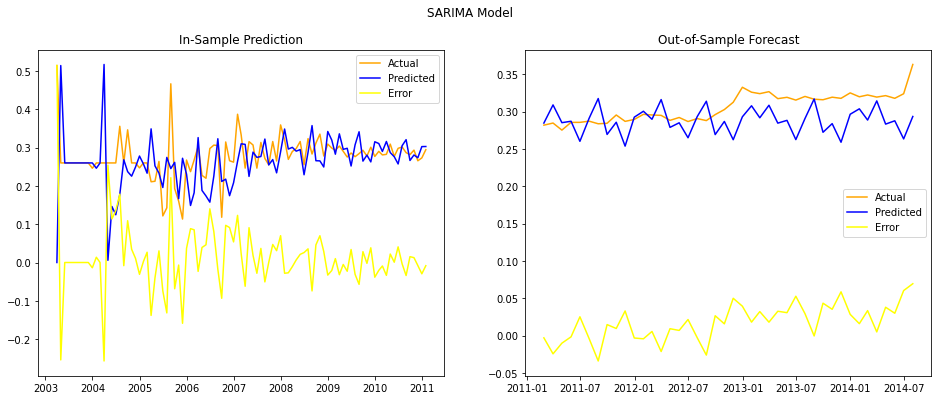

In [ ]:
saim1_train = pd.DataFrame({'Actual':tr_blob,'Predicted':sarima1_train_pred})
saim1_test = pd.DataFrame({'Actual':ts_blob,'Predicted':sarima1_test_pred})
saim1_train['Error']=saim1_train['Actual']-saim1_train['Predicted']
saim1_test['Error']=saim1_test['Actual']-saim1_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saim1_train['Actual'],color='orange',label='Actual')
plt.plot(saim1_train['Predicted'],color='blue',label='Predicted')
plt.plot(saim1_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
plt.plot(saim1_test['Actual'],color='orange',label='Actual')
plt.plot(saim1_test['Predicted'],color='blue',label='Predicted')
plt.plot(saim1_test['Error'],color='yellow',label='Error')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMA Model');

In [ ]:
np.sqrt(mean_squared_error(saim1_test.Actual,saim1_test.Predicted))

0.030022861309581345

In [ ]:
np.sqrt(mean_squared_error(saim1_train.Actual,saim1_train.Predicted))

0.0926391146748011

**SARIMAX**

Exog values prediction

In [ ]:
exog_train = tr['overall']
exog_test = ts['overall']

In [ ]:
# exog_p={}
# exog_p1={}
# # d=0
# for p in range(1,5):
#   for d in range(1,3):
#     for q in range(1,5):
#         m1 = SARIMAX(exog_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         exog_p[f'({p},{d},{q})']=m1.aic
#         exog_p1[f'({p},{d},{q})']=m1.llf
# min(exog_p,key=exog_p.get),max(exog_p1,key=exog_p1.get)

In [ ]:
sarima1 = SARIMAX(exog_train,order=(1,1,1),seasonal_order=(4,1,4,12)).fit()
sarima1_train_pred = sarima1.predict(0,(len(exog_train)-1))
sarima1_test_pred = sarima1.predict(len(exog_train),(len(exog_train)+len(exog_test)-1))
# print(sarima.summary())
ljung5 = sm.stats.acorr_ljungbox(sarima1.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung5}')

LJung Box Test Value : [0.20476001]


In [ ]:
fcast_exog = sarima1.predict(start=len(exog_train)+len(exog_test), end=len(exog_train)+len(exog_test)+20, typ='levels')
print(fcast_exog.head())

2014-08-31    4.588971
2014-09-30    4.656197
2014-10-31    4.642051
2014-11-30    4.699783
2014-12-31    4.683796
Freq: M, Name: predicted_mean, dtype: float64


SARIMAX Prediction

In [ ]:
# sarx_p={}
# sarxx_p={}
# # d=0
# for p in range(1,5):
#   for d in range(1,3):
#     for q in range(1,5):
#         m1 = SARIMAX(tr_blob,order=(p,d,q),seasonal_order=(p,d,q,12),exog=exog_train).fit()
#         sarx_p[f'({p},{d},{q})']=m1.aic
#         sarxx_p[f'({p},{d},{q})']=m1.llf
# min(sarx_p,key=sarx_p.get),max(sarxx_p,key=sarxx_p.get)

In [ ]:
sarimax = SARIMAX(tr_blob,order=(4,1,3),seasonal_order=(4,1,3,12),exog = exog_train.values).fit()
sarimax_train_pred = sarimax.predict(0,(len(tr_blob)-1))
sarimax_test_pred = sarimax.forecast(len(ts_blob),exog=exog_test.values)
print(sarimax.summary())
ljung4 = sm.stats.acorr_ljungbox(sarimax.resid,lags=[1],return_df=True)['lb_pvalue'].values
if ljung4 < 0.05:
  print(f'LJung Box Test Value : {ljung4}, Model Rejected.')
else:
  print(f'LJung Box Test Value : {ljung4}, Model Accepted.')

                                     SARIMAX Results                                      
Dep. Variable:                           polarity   No. Observations:                   95
Model:             SARIMAX(4, 1, 3)x(4, 1, 3, 12)   Log Likelihood                 110.888
Date:                            Mon, 20 Jun 2022   AIC                           -189.777
Time:                                    15:32:36   BIC                           -151.269
Sample:                                03-31-2003   HQIC                          -174.317
                                     - 01-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0630      0.024      2.673      0.008       0.017       0.109
ar.L1         -0.8194      0.195   

In [ ]:
fort=sarimax.forecast(len(ts_blob)+21,exog=list(exog_test.values)+list(fcast_exog.values))

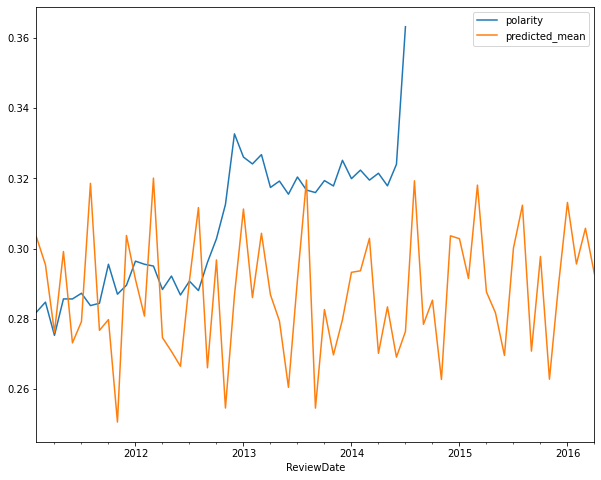

In [ ]:
ts_blob.plot(figsize=(10,8),legend=True,sharex=True)
fort.plot(legend=True)
plt.show()

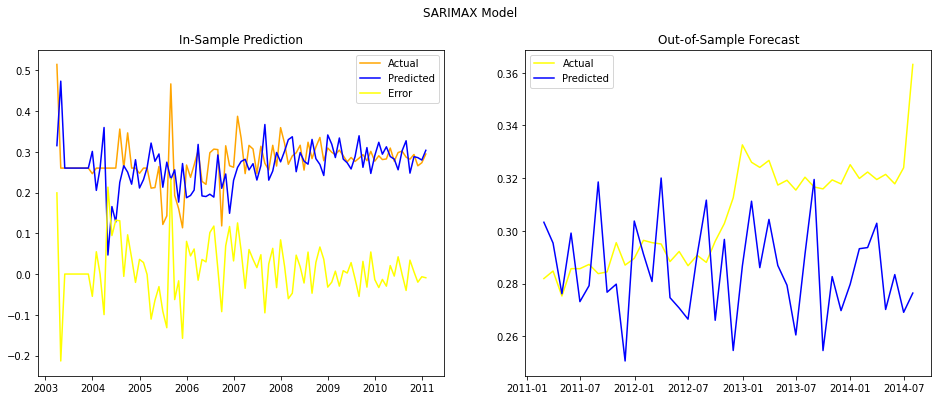

In [ ]:
saimx_train = pd.DataFrame({'Actual':tr_blob,'Predicted':sarimax_train_pred})
# saimx_test = pd.DataFrame({'Actual':ts_blob,'Predicted':sarimax_test_pred})
saimx_train['Error']=saimx_train['Actual']-saimx_train['Predicted']
# saimx_test['Error']=saimx_test['Actual']-saimx_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saimx_train['Actual'],color='orange',label='Actual')
plt.plot(saimx_train['Predicted'],color='blue',label='Predicted')
plt.plot(saimx_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
# plt.plot(saimx_test['Actual'],color='orange',label='Actual')
plt.plot(ts_blob,color='yellow',label='Actual')
plt.plot(sarimax_test_pred,color='blue',label='Predicted')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMAX Model');

In [ ]:
np.sqrt(mean_squared_error(ts_blob,sarimax_test_pred))

0.033503501896125845

In [ ]:
np.sqrt(mean_squared_error(saimx_train.Actual,saimx_train.Predicted))

0.07160446656800092

### Negative Sentiment

In [ ]:
neg_blob=negative_blob[[x for x in negative_blob.columns if negative_blob[x].dtype !='O']]
# neg_blob

In [ ]:
neg_blob=neg_blob.resample('M').mean()

In [ ]:
neg_blob['overall'].median()

1.7436812004181785

In [ ]:
neg_blob['polarity'].median()

0.027965184001269402

In [ ]:
# pos_blob['helpful'].fillna(0.6,inplace=True)
neg_blob['overall'].fillna(2.6,inplace=True)
neg_blob['polarity'].fillna(-0.11,inplace=True)

In [ ]:
ntr = neg_blob.iloc[:(int(0.7 * len(neg_blob)))]
nts = neg_blob.iloc[(int(0.7 * len(neg_blob))):]
ntr_blob = ntr['polarity']
nts_blob = nts['polarity']

Exog Values Prediciton

In [ ]:
exogn_train = ntr['overall']
exogn_test = nts['overall']

In [ ]:
# exog_n={}
# exog_n1={}
# # d=0
# for p in range(1,5):
#   for d in range(1,3):
#     for q in range(1,5):
#         m1 = SARIMAX(exogn_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         exog_n[f'({p},{d},{q})']=m1.aic
#         exog_n1[f'({p},{d},{q})']=m1.llf
# min(exog_n,key=exog_n.get),max(exog_n1,key=exog_n1.get)

In [ ]:
sariman1 = SARIMAX(exogn_train,order=(1,1,1),seasonal_order=(1,1,1,12)).fit()
sariman1_train_pred = sariman1.predict(0,(len(exogn_train)-1))
sariman1_test_pred = sariman1.predict(len(exogn_train),(len(exogn_train)+len(exogn_test)-1))
# print(sarima.summary())
ljung6 = sm.stats.acorr_ljungbox(sariman1.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung6}')

LJung Box Test Value : [0.48096472]


In [ ]:
fcast_exogn = sariman1.predict(start=len(exogn_train)+len(exogn_test), end=len(exogn_train)+len(exogn_test)+20, typ='levels')
print(fcast_exogn.head())

2014-08-31    1.358227
2014-09-30    1.200510
2014-10-31    1.072837
2014-11-30    1.242913
2014-12-31    1.155491
Freq: M, Name: predicted_mean, dtype: float64


SARIMAX Prediciton

In [ ]:
# sarx_n={}
# sarxx_n={}
# # d=0
# for p in range(1,5):
#   for d in range(1,3):
#     for q in range(1,5):
#         m1 = SARIMAX(ntr_blob,order=(p,d,q),seasonal_order=(p,d,q,12),exog=exogn_train).fit()
#         sarx_n[f'({p},{d},{q})']=m1.aic
#         sarxx_n[f'({p},{d},{q})']=m1.llf
# min(sarx_n,key=sarx_n.get),max(sarxx_n,key=sarxx_n.get)

In [ ]:
sarimaxn = SARIMAX(ntr_blob,order=(1,1,4),seasonal_order=(1,1,4,12),exog = exogn_train.values).fit()
sarimaxn_train_pred = sarimaxn.predict(0,(len(ntr_blob)-1))
sarimaxn_test_pred = sarimaxn.forecast(len(nts_blob),exog=exogn_test.values)
print(sarimaxn.summary())
ljung4 = sm.stats.acorr_ljungbox(sarimaxn.resid,lags=[1],return_df=True)['lb_pvalue'].values
if ljung4 < 0.05:
  print(f'LJung Box Test Value : {ljung4}, Model Rejected.')
else:
  print(f'LJung Box Test Value : {ljung4}, Model Accepted.')

                                     SARIMAX Results                                      
Dep. Variable:                           polarity   No. Observations:                   83
Model:             SARIMAX(1, 1, 4)x(1, 1, 4, 12)   Log Likelihood                  52.957
Date:                            Mon, 20 Jun 2022   AIC                            -81.915
Time:                                    15:32:49   BIC                            -54.933
Sample:                                09-30-2004   HQIC                           -71.197
                                     - 07-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0770      0.024     -3.213      0.001      -0.124      -0.030
ar.L1         -0.8140      0.514   

In [ ]:
fortn=sarimaxn.forecast(len(nts_blob)+21,exog=list(exogn_test.values)+list(fcast_exogn.values))

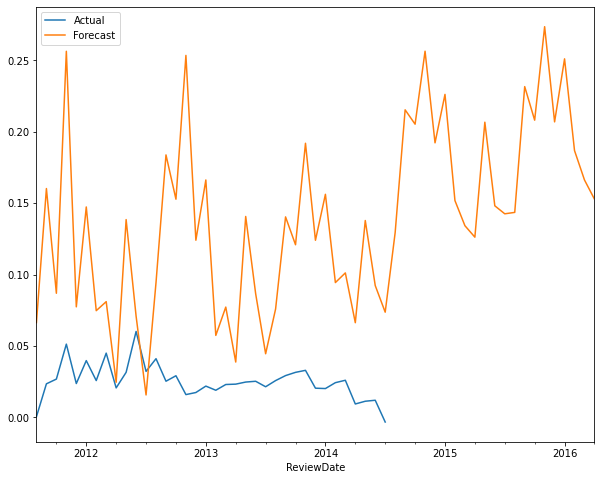

In [ ]:
nts_blob.plot(figsize=(10,8),legend=True,sharex=True,label='Actual')
fortn.plot(legend=True,label='Forecast')
plt.show()

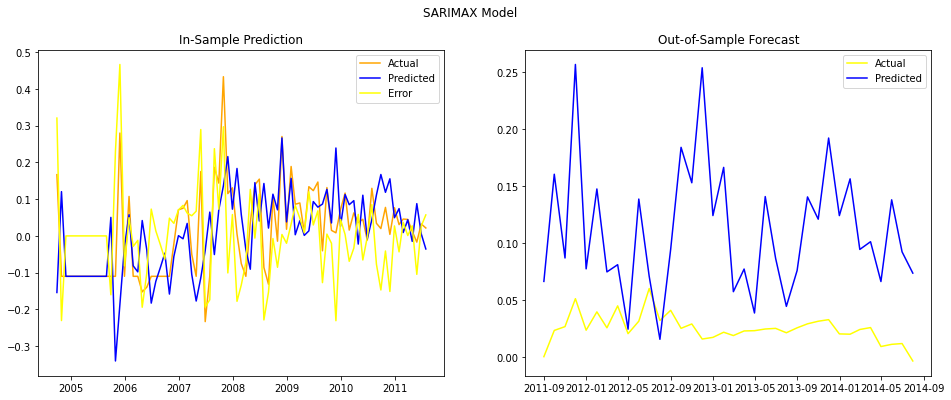

In [ ]:
saimxn_train = pd.DataFrame({'Actual':ntr_blob,'Predicted':sarimaxn_train_pred})
# saimx_test = pd.DataFrame({'Actual':ts_blob,'Predicted':sarimax_test_pred})
saimxn_train['Error']=saimxn_train['Actual']-saimxn_train['Predicted']
# saimx_test['Error']=saimx_test['Actual']-saimx_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saimxn_train['Actual'],color='orange',label='Actual')
plt.plot(saimxn_train['Predicted'],color='blue',label='Predicted')
plt.plot(saimxn_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
# plt.plot(saimx_test['Actual'],color='orange',label='Actual')
plt.plot(nts_blob,color='yellow',label='Actual')
plt.plot(sarimaxn_test_pred,color='blue',label='Predicted')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMAX Model');

In [ ]:
np.sqrt(mean_squared_error(nts_blob,sarimaxn_test_pred))

0.10174518393009412

In [ ]:
np.sqrt(mean_squared_error(saimxn_train.Actual,saimxn_train.Predicted))

0.12148684904618841

### Average Sentiment

In [ ]:
avg_blob=trial[[x for x in trial.columns if trial[x].dtype !='O']]
# avg_blob

In [ ]:
avg_blob=avg_blob.resample('M').mean()

In [ ]:
avg_blob['overall'].median()

4.229957959291939

In [ ]:
avg_blob['polarity'].median()

0.2438655043978265

In [ ]:
# pos_blob['helpful'].fillna(0.6,inplace=True)
avg_blob['overall'].fillna(4.2,inplace=True)
avg_blob['polarity'].fillna(0.24,inplace=True)

In [ ]:
nrtr = avg_blob.iloc[:(int(0.7 * len(avg_blob)))]
nrts = avg_blob.iloc[(int(0.7 * len(avg_blob))):]
nrtr_blob = nrtr['polarity']
nrts_blob = nrts['polarity']

Exog Values Prediction

In [ ]:
exognr_train = nrtr['overall']
exognr_test = nrts['overall']

In [ ]:
# exog_nr={}
# exog_nr1={}
# # d=0
# for p in range(1,5):
#   for d in range(0,1):
#     for q in range(1,5):
#         m1 = SARIMAX(exognr_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
#         exog_nr[f'({p},{d},{q})']=m1.aic
#         exog_nr1[f'({p},{d},{q})']=m1.llf
# min(exog_nr,key=exog_nr.get),max(exog_nr1,key=exog_nr1.get)

In [ ]:
sarimanr1 = SARIMAX(exognr_train,order=(4,0,4),seasonal_order=(4,0,4,12)).fit()
sarimanr1_train_pred = sarimanr1.predict(0,(len(exognr_train)-1))
sarimanr1_test_pred = sarimanr1.predict(len(exognr_train),(len(exognr_train)+len(exognr_test)-1))
# print(sarima.summary())
ljung7 = sm.stats.acorr_ljungbox(sarimanr1.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(f'LJung Box Test Value : {ljung7}')

LJung Box Test Value : [0.22188537]


In [ ]:
fcast_exognr = sarimanr1.predict(start=len(exognr_train)+len(exognr_test), end=len(exognr_train)+len(exognr_test)+20, typ='levels')
print(fcast_exognr.head())

2014-08-31    4.185581
2014-09-30    4.166376
2014-10-31    4.171081
2014-11-30    4.222691
2014-12-31    4.140122
Freq: M, Name: predicted_mean, dtype: float64


SARIMAX Prediction

In [ ]:
# sarx_nr={}
# sarxx_nr={}
# # d=0
# for p in range(1,5):
#   for d in range(0,1):
#     for q in range(1,5):
#         m1 = SARIMAX(nrtr_blob,order=(p,d,q),seasonal_order=(p,d,q,12),exog=exognr_train).fit()
#         sarx_nr[f'({p},{d},{q})']=m1.aic
#         sarxx_nr[f'({p},{d},{q})']=m1.llf
# min(sarx_nr,key=sarx_nr.get),max(sarxx_nr,key=sarxx_nr.get)

In [ ]:
sarimaxnr = SARIMAX(nrtr_blob,order=(4,0,4),seasonal_order=(4,0,4,12),exog = exognr_train.values).fit()
sarimaxnr_train_pred = sarimaxnr.predict(0,(len(nrtr_blob)-1))
sarimaxnr_test_pred = sarimaxnr.forecast(len(nrts_blob),exog=exognr_test.values)
print(sarimaxnr.summary())
ljung8 = sm.stats.acorr_ljungbox(sarimaxnr.resid,lags=[1],return_df=True)['lb_pvalue'].values
if ljung8 < 0.05:
  print(f'LJung Box Test Value : {ljung8}, Model Rejected.')
else:
  print(f'LJung Box Test Value : {ljung8}, Model Accepted.')

                                     SARIMAX Results                                      
Dep. Variable:                           polarity   No. Observations:                  102
Model:             SARIMAX(4, 0, 4)x(4, 0, 4, 12)   Log Likelihood                 179.457
Date:                            Mon, 20 Jun 2022   AIC                           -322.914
Time:                                    15:33:22   BIC                           -275.665
Sample:                                06-30-2002   HQIC                          -303.781
                                     - 11-30-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0552      0.001     47.981      0.000       0.053       0.057
ar.L1         -0.2409      1.367   

In [ ]:
fortnr=sarimaxnr.forecast(len(nrts_blob)+21,exog=list(exognr_test.values)+list(fcast_exognr.values))

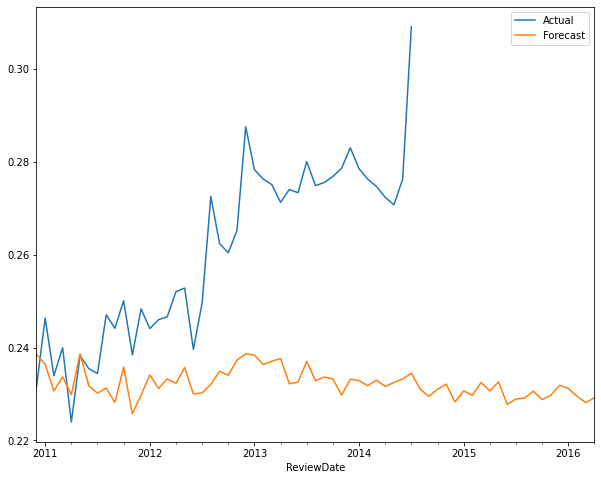

In [ ]:
nrts_blob.plot(figsize=(10,8),legend=True,sharex=True,label='Actual')
fortnr.plot(legend=True,label='Forecast')
plt.show()

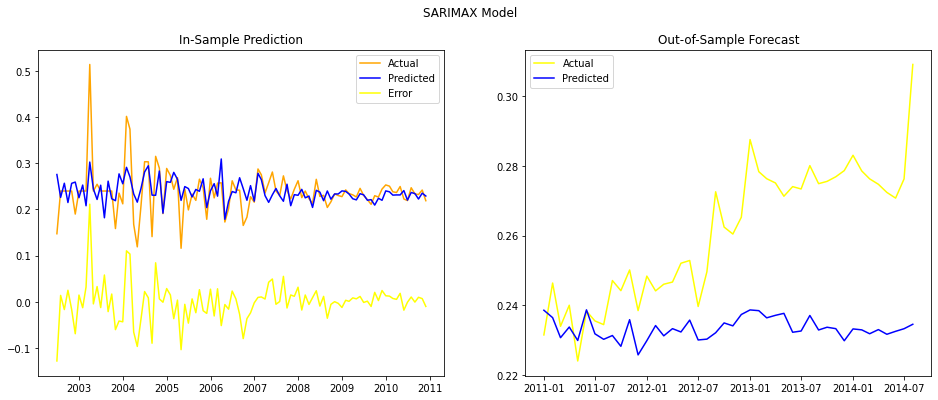

In [ ]:
saimxnr_train = pd.DataFrame({'Actual':nrtr_blob,'Predicted':sarimaxnr_train_pred})
# saimx_test = pd.DataFrame({'Actual':ts_blob,'Predicted':sarimax_test_pred})
saimxnr_train['Error']=saimxnr_train['Actual']-saimxnr_train['Predicted']
# saimx_test['Error']=saimx_test['Actual']-saimx_test['Predicted']
plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(saimxnr_train['Actual'],color='orange',label='Actual')
plt.plot(saimxnr_train['Predicted'],color='blue',label='Predicted')
plt.plot(saimxnr_train['Error'],color='yellow',label='Error')
plt.title('In-Sample Prediction')
plt.legend()
plt.subplot(1,2,2)
# plt.plot(saimx_test['Actual'],color='orange',label='Actual')
plt.plot(nrts_blob,color='yellow',label='Actual')
plt.plot(sarimaxnr_test_pred,color='blue',label='Predicted')
plt.title('Out-of-Sample Forecast')
plt.legend()
plt.suptitle('SARIMAX Model');

In [ ]:
np.sqrt(mean_squared_error(nrts_blob,sarimaxnr_test_pred))

0.03271148782765166

In [ ]:
np.sqrt(mean_squared_error(saimxnr_train.Actual,saimxnr_train.Predicted))

0.04231798745034528

# Analysis

In [ ]:
positive1.head(2)

ReviewDate
2002-06-30    3
2002-07-31    0
Freq: M, Name: productID, dtype: int64

In [ ]:
positive1=pd.DataFrame(positive1)

In [ ]:
positive1['category']='Beauty'

In [ ]:
positive1.head(2)

,productID,category
ReviewDate,,
2002-06-30,3,Beauty
2002-07-31,0,Beauty


In [ ]:
positivec1=pd.DataFrame(positivec1)

In [ ]:
positivec1['category']='Clothing-Shoes-Jewelry'

In [ ]:
positivec1.head(2)

,productID,category
ReviewDate,,
2003-03-31,1,Clothing-Shoes-Jewelry
2003-04-30,0,Clothing-Shoes-Jewelry


In [ ]:
test=pd.concat([positive1,positivec1],axis=0)

In [ ]:
test.head(2)

,productID,category
ReviewDate,,
2002-06-30,3,Beauty
2002-07-31,0,Beauty


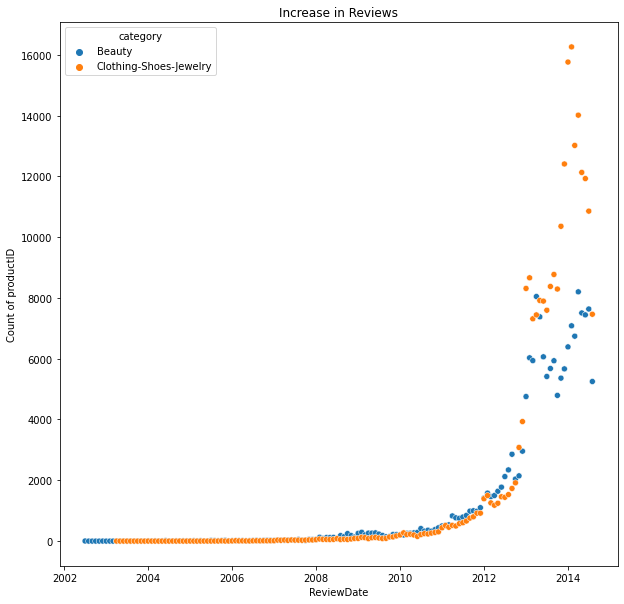

In [ ]:
fig=plt.subplots(figsize=(10,10))
sns.scatterplot(x=test.index ,y=test.productID,hue=test.category)
plt.ylabel('Count of productID')
plt.title('Increase in Reviews')
plt.show()

In [ ]:
review.head(1)

,reviewerID,productID,helpful,overall,ReviewDate,category,review,pro_review,sentiment,pred_sentiment,polarity,blob_sentiment
0,A1YJEY40YUW4SE,7806397051,0.75,1,2014-01-30,Beauty,Very oily and creamy. Not at all what I expect...,oily creamy expected ordered try highlight con...,Negative,Negative,-0.275,Negative
